In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ast
import wordcloud

from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Recipe Recommendation System with sklearn
## Solving the 'What's for dinner?' problem the scientific way

_D. Tuleva_

_Final Project for Data Science June 2023, SoftUni_

<div style="width: 600px; text-align: justify; padding-left: 100px;"> 
    <h4>Abstract</h4>
    
    This work aims to create a content-based recommendation system for food recipes. Recipe related data is acquired, cleaned and processed and a model is trained and evaluated using pandas and sklearn; visualization utilizes matplotlib. Features on focus are recipe title, ingredients, cooking instructions, cooking times and user rating, our unsupervised clustering model does not account for recipe categories. 

</div>

###  Helper functions

 Some helper functios related to list columns

In [3]:
# Prints first n values from specified column in a pd.DataFrame   
def print_values_in_first_n_rows(dataset, column_name, n = 5, is_list = False):
    for row, column_value in enumerate(dataset[column_name]):
        if is_list:
            print(*column_value, sep=", ")
        else:
            print(column_value)
        print()
        if row >= n - 1:
            break
            

# Returns flattened list of all item occurrences (lowercase) from specified column in a pd.DataFrame 
# Assumes initial values in the column are of type list
def item_occurences_lst(dataset, column_name):
    result = dataset[column_name][dataset[column_name].notna()] # Series of valid list values
    result = [item.lower() for item_list in result for item in item_list]
    return result
    

def plot_hist_from_value_counts(dataset, column_name, item_name = "ingredient"):
    value_counts_lst = dataset[column_name].value_counts()
    plt.bar(np.arange(1, len(value_counts_lst) +1), value_counts_lst, width = 1)
    
    plt.xlabel(f"N-th {item_name}")
    plt.ylabel("Occurrences")
    plt.semilogy()
    
    plt.show()
    

def plot_hist_from_counter_object(counter_obj, item_name = "ingredient"):
    item_counts_lst = [item[1] for item in counter_obj.most_common()]

    plt.bar(np.arange(1, len(item_counts_lst) + 1), item_counts_lst, width = 1)

    plt.xlabel(f"N-th {item_name}")
    plt.ylabel("Occurrences")
    plt.semilogy()

    plt.show()
    

def plot_first_last_n_from_counter_object(counter_obj, n = 10, item_name = "Ingredients"):
    most_common_lst = counter_obj.most_common()
    n_most_common = most_common_lst[:n]
    n_least_common = most_common_lst[-n:]
    n_most_common_keys = [item[0] for item in n_most_common]
    n_most_common_values = [item[1] for item in n_most_common]
    n_least_common_keys = [item[0].replace("\n", "\\n") for item in n_least_common] # escapes newline char in plot labels
    n_least_common_values = [item[1] for item in n_least_common]

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 20))
    fig.subplots_adjust(hspace=0.1)
  
    ax1.barh(n_most_common_keys, n_most_common_values)
    ax2.barh(n_least_common_keys, n_least_common_values)

    ax1.invert_yaxis()
    ax2.invert_yaxis()

    ax1.set_title(f"{n} Most and Least Common {item_name}")

    # broken axis
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.tick_params(labeltop=True)
    ax1.xaxis.tick_top()
    ax2.xaxis.tick_bottom()
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    plt.show()

        

### Table of contents

1. [Introduction](#introduction)

    1.1. [Related work](#related_work)

2. [Datasets - cleaning and EDA](#datasets)

   2.1. [Food.com - Recipes and Reviews](#datasets_one)
    
   2.2. [Allrecipes.com - foodRecSys-V1](#datasets_two)

   2.3. [Epicurious.com - Food Ingredients and Recipes Dataset with Images](#datasets_three)

   2.4. [foodRecSys-V1](#datasets_four)

3. [Preprocessing data](#preprocess)

4. [Model](#model)

5. [Conclusion](#conclusion)

6. [References](#ref)
   




<a id="introduction"></a>
### 1. Introduction


Recommendation systems are algorithms and techniques used to provide personalized suggestions to users, helping them discover relevant items from a vast pool of options. These systems leverage data analysis and machine learning to predict user preferences and optimize the user experience and therefore boost site traffic and/or sales. There are many different types of recommendation systems - collaborative (recommends items based on user behavior patterns), content-based (suggests items by analyzing their attributes), hybrid (combines different recommendation approaches), session-based, demographic-based and other. In our work we explore recipes features with the hope to model content-based similarity.

<a id="related_work"></a>
#### 1.1 Related work

[References](#ref)

In [RECipe: Does a Multi-Modal Recipe Knowledge Graph Fit a Multi-Purpose Recommendation System?](https://arxiv.org/pdf/2308.04579.pdf)  ALI PESARANGHADER and TOUQIR SAJED devise a framework combining behavior-based recommendation, text-based recommendation and image-based recommendation specifically for recipes. Their model generates recommendations from text-promt, image or both utilising two knowledge graphs. Recreating their extensive work is outside of our capabilities, but the article was very useful for translating general recipe and cooking knowledge into machine learning terms. Also this is we found our two basic datasets.

Another article our work is greatly influenced by is [Recipe1M+: A Dataset for Learning Cross-Modal Embeddings for Cooking Recipes and Food Images](https://arxiv.org/pdf/1810.06553v2.pdf). This paper is about the creation of Recipe1M+ - a large-scale, structured corpus of over one million cooking recipes and 13
million food images, which is also the base for the RecipeNLG dataset we use in our work.

Some other articles we used for inspiration and guidance of our work are [Article Recommendation System Using Python](https://medium.com/web-mining-is688-spring-2021/article-recommendation-system-using-python-8b0fec6e6de8) - a recommendation model based on cosine similarity on text features; [Word Embedding Explained, a comparison and code tutorial](https://medium.com/@dcameronsteinke/tf-idf-vs-word-embedding-a-comparison-and-code-tutorial-5ba341379ab0) - a begginner-friendly explanation of basic text processing with sklearn; and [K-Nearest Neighbors: All you need to know](https://medium.com/analytics-vidhya/k-nearest-neighbors-all-you-need-to-know-1333eb5f0ed0) - movie recommendation with KNN explained in detail.

<a id="datasets"></a>
### 2. Datasets

[Datasets](#DS)

<a id="datasets_one"></a>
### 2.1. Food.com - Recipes and Reviews

Data on recipes and reviews from Food.com, publicly available at [kaggle.com](https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews) The recipes dataset contains 522,517 recipes with category, information about cooking times, servings, ingredients, nutrition, instructions, and more.
The reviews dataset contains 1,401,982 reviews from 271,907 different users with information about the author, rating, review text, and more.

Both datasets are provided in two different formats - .parquet and .csv; in our work we use the .csv. Since it is designed to be parsed in R additional processing of list columns is required.

In [4]:
recipes_food_com = pd.read_csv("data/food.com-Recipes_and_Reviews/recipes.csv")

In [5]:
recipes_food_com.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


In [6]:
recipes_food_com.shape

(522517, 28)

In [7]:
recipes_food_com.dtypes

RecipeId                        int64
Name                           object
AuthorId                        int64
AuthorName                     object
CookTime                       object
PrepTime                       object
TotalTime                      object
DatePublished                  object
Description                    object
Images                         object
RecipeCategory                 object
Keywords                       object
RecipeIngredientQuantities     object
RecipeIngredientParts          object
AggregatedRating              float64
ReviewCount                   float64
Calories                      float64
FatContent                    float64
SaturatedFatContent           float64
CholesterolContent            float64
SodiumContent                 float64
CarbohydrateContent           float64
FiberContent                  float64
SugarContent                  float64
ProteinContent                float64
RecipeServings                float64
RecipeYield 

We make sure there are no duplicate values in the "RecipeId" column and set it as the index of the dataframe:

In [8]:
assert(len(recipes_food_com.RecipeId.unique()) == recipes_food_com.shape[0])

In [9]:
recipes_food_com = recipes_food_com.set_index("RecipeId")

In [10]:
recipes_food_com.head(2)

,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
RecipeId,,,,,,,,,,,,,,,,,,,,,
38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."


Let's look at the Name column:

In [11]:
recipes_food_com.Name.value_counts()

Name
Banana Bread                 186
Chicken Enchiladas           132
Beef Stroganoff              126
Chocolate Chip Cookies       115
Sweet Potato Casserole       113
                            ... 
Valencia Corn Salad            1
Wet Fried Calamari             1
Louisiana Pecan Balls          1
Carrot Raisin Nut Muffins      1
Spicy Baked Scotch Eggs        1
Name: count, Length: 438188, dtype: int64

In [12]:
recipes_food_com[recipes_food_com.Name == recipes_food_com.Name.value_counts().idxmax()].head(3)

,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
RecipeId,,,,,,,,,,,,,,,,,,,,,
9244,Banana Bread,9690,Cheryl E,PT1H,PT10M,PT1H10M,2001-06-01T11:15:00Z,Make and share this Banana Bread recipe from F...,"c(""https://img.sndimg.com/food/image/upload/w_...",Quick Breads,...,18.0,372.0,2815.6,495.1,16.1,263.0,42.9,NaN,1 loaf pan,"c(""In a bowl beat together brown sugar and oil..."
9353,Banana Bread,6357,Charishma_Ramchanda,PT1H,PT10M,PT1H10M,2001-06-04T16:50:00Z,Make and share this Banana Bread recipe from F...,"c(""https://img.sndimg.com/food/image/upload/w_...",Quick Breads,...,1.1,31.4,228.1,34.7,1.0,21.6,3.0,NaN,12 slices,"c(""Mash bananas in a bowl."", ""Add eggs and sti..."
10131,Banana Bread,12200,Tom Lambie,PT1H,PT20M,PT1H20M,2001-07-11T08:39:00Z,I have made this bread for Christmas for the l...,"c(""https://img.sndimg.com/food/image/upload/w_...",Quick Breads,...,4.0,46.5,243.1,53.8,2.1,30.7,5.2,NaN,1 loaf,"c(""Mix all the wet ingredients together until ..."


Clearly we have duplicate names, but other columns' content suggests these are different recipes for the same dish, which is valuable information, so removing duplicate names is not needed. We check if there are whole rows with the same content:

In [13]:
duplicates = recipes_food_com[recipes_food_com.duplicated(keep = False)]
len(duplicates)

135

A small number of rows that we can drop, just let us see one sample of a duplicate row:

In [14]:
sample_duplicate_idx = () 
for group, group_data in duplicates.groupby(["Name", "AuthorId"]):
    sample_duplicate_idx = group
    print(sample_duplicate_idx)
    break

('Apricot Citrus Cranberry Compote', 82761)


In [15]:
recipes_food_com[(recipes_food_com.Name == sample_duplicate_idx[0]) & (recipes_food_com.AuthorId == sample_duplicate_idx[1])]

,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
RecipeId,,,,,,,,,,,,,,,,,,,,,
539657,Apricot Citrus Cranberry Compote,82761,DJM70,PT15M,PT10M,PT25M,2019-12-20T21:36:00Z,Make and share this Apricot Citrus Cranberry C...,character(0),Fruit,...,0.0,0.0,3.9,51.0,3.6,42.5,1.7,6.0,NaN,"c(""in a small saucepan combine 1/3 cup of the ..."
539658,Apricot Citrus Cranberry Compote,82761,DJM70,PT15M,PT10M,PT25M,2019-12-20T21:36:00Z,Make and share this Apricot Citrus Cranberry C...,character(0),Fruit,...,0.0,0.0,3.9,51.0,3.6,42.5,1.7,6.0,NaN,"c(""in a small saucepan combine 1/3 cup of the ..."


In [16]:
recipes_food_com = recipes_food_com.drop_duplicates()

In [17]:
recipes_food_com.head(2)

,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
RecipeId,,,,,,,,,,,,,,,,,,,,,
38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."


As food "healthiness" is very controversial theme, in order to avoid making general assumptions without extensive research we exclude all features related to calorie and nutritional content:

In [18]:
recipes_food_com = recipes_food_com.drop(columns = [
    "Calories",
    "FatContent",
    "SaturatedFatContent",
    "CholesterolContent",
    "SodiumContent",
    "CarbohydrateContent",
    "FiberContent",
    "SugarContent",
    "ProteinContent"
])

We explore the RecipeServings and RecipeYield features:

In [19]:
recipes_food_com.RecipeServings.dtype, recipes_food_com.RecipeYield.dtype

(dtype('float64'), dtype('O'))

In [20]:
recipes_food_com.RecipeServings.describe()

count    339559.000000
mean          8.606366
std         114.327702
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max       32767.000000
Name: RecipeServings, dtype: float64

Well, 32767 is an absurd number of servings. We need to find a reasonable value for maximum number of servings over with we assume the value is a mistake and replace it with NaN. First we tried with 25 (over standard 24-piece cake) and found cookie and small bread and dessert recipes counted by the piece that legitimately have up to 100 - 150 servings. Over 150 we see many recipes for sauces and salad dressings with very high values of servings, but the values seem plausible because of the big quantities of ingredients and expected small portion size. Here are the entries with more than 1000 servings:

In [21]:
# recipes_food_com[recipes_food_com.RecipeServings > 1000]

In [22]:
# plot outliers with interquantle range

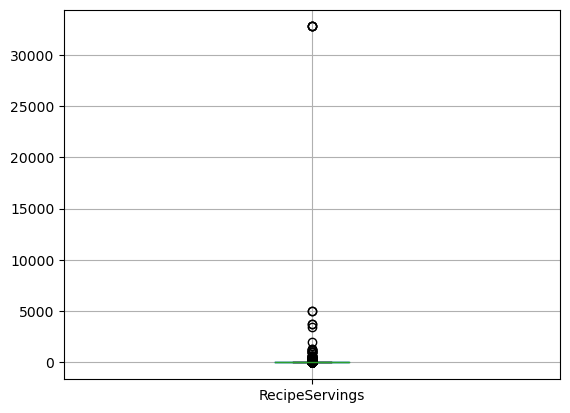

In [25]:
recipes_food_com.boxplot(column="RecipeServings")
plt.show()

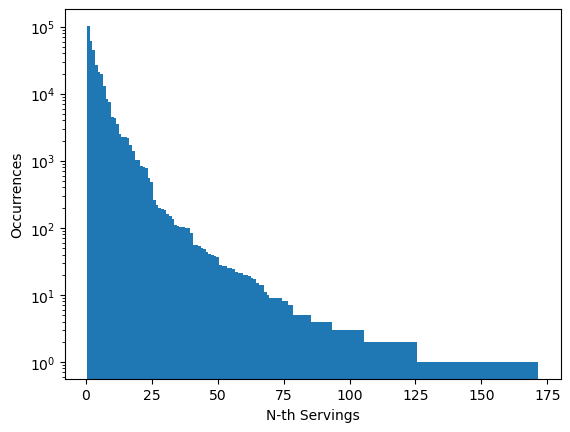

In [26]:
plot_hist_from_value_counts(recipes_food_com, "RecipeServings", item_name = "Servings")

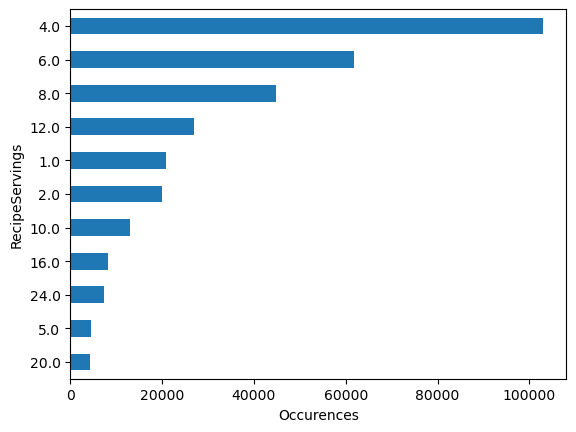

In [43]:
recipes_food_com.RecipeServings.value_counts(ascending = True)[20:].plot(kind="barh")
plt.xlabel("Occurences")
plt.show()

In [58]:
recipes_food_com.RecipeServings.value_counts()[recipes_food_com.RecipeServings.value_counts() < 2].index


Index([ 340.0, 1200.0,  328.0,  204.0,  608.0,  201.0,  345.0,  118.0,  365.0,
        191.0, 1012.0,  105.0,  412.0, 1215.0,  190.0,   73.0,  610.0,  195.0,
        420.0, 2000.0,  270.0,  224.0,  134.0,  390.0,   69.0, 3500.0,  203.0,
        600.0,  480.0,  135.0,  114.0, 1280.0,  410.0, 1296.0,  156.0,  121.0,
         99.0,  288.0,  136.0,  216.0,  276.0,  830.0,  336.0,   91.0, 1210.0,
        228.0],
      dtype='float64', name='RecipeServings')

Although some have "For large groups" keyword RecipeServings values do not seem accurate and we replace them with nans:

In [22]:
recipes_food_com.loc[recipes_food_com.RecipeServings > 1000, "RecipeServings"] = np.NaN

In [23]:
recipes_food_com.RecipeServings.describe()

count    339543.000000
mean          8.131483
std          11.180643
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max        1000.000000
Name: RecipeServings, dtype: float64

In [24]:
recipes_food_com.RecipeServings.isna().count()

522449

In [25]:
recipes_food_com.RecipeYield.unique()

array([nan, '4 kebabs', '1 9-inch pie', ..., '5 pastries',
       '1 9× 13 cake pan', '7-8 Mini loaves'], dtype=object)

In [26]:
recipes_food_com.RecipeYield.nunique()

34043

In [27]:
recipes_food_com.RecipeYield.isna().count()

522449

A lot of missing values, high entropy (huge range for RecipeServings and too many unique values for RecipeYield). Together with the fact that a recipe quantity could be easily adjusted even from a reader with basic cooking skills makes this features not very beneficial to the analysis and we drop them. As we decided to not keep recipe quantity measures, we do not need the RecipeIngredientQuantities column too.

In [28]:
recipes_food_com = recipes_food_com.drop(columns = ["RecipeServings", "RecipeYield", "RecipeIngredientQuantities"])

In [29]:
recipes_food_com.head(3)

,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientParts,AggregatedRating,ReviewCount,RecipeInstructions
RecipeId,,,,,,,,,,,,,,,
38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""blueberries"", ""granulated sugar"", ""vanilla ...",4.5,4.0,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""saffron"", ""milk"", ""hot green chili peppers""...",3.0,1.0,"c(""Soak saffron in warm milk for 5 minutes and..."
40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",Beverages,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",4.5,10.0,"c(""Into a 1 quart Jar with tight fitting lid, ..."


In [30]:
for column in ["CookTime", "PrepTime", "TotalTime"]:
    hours = recipes_food_com[column].str.extract('(\d*)H')
    hours[hours.isna()] = 0
    # hours[hours == ""] = 0
    hours = hours.astype("int")

    minutes = recipes_food_com[column].str.extract('(\d*)M')
    minutes[minutes.isna()] = 0
    minutes = minutes.astype("int")

    recipes_food_com[column] = hours * 60 + minutes
    
    

In [31]:
recipes_food_com.head()

,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientParts,AggregatedRating,ReviewCount,RecipeInstructions
RecipeId,,,,,,,,,,,,,,,
38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,1440,45,1485,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""blueberries"", ""granulated sugar"", ""vanilla ...",4.5,4.0,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
39,Biryani,1567,elly9812,25,240,265,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""saffron"", ""milk"", ""hot green chili peppers""...",3.0,1.0,"c(""Soak saffron in warm milk for 5 minutes and..."
40,Best Lemonade,1566,Stephen Little,5,30,35,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",Beverages,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",4.5,10.0,"c(""Into a 1 quart Jar with tight fitting lid, ..."
41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,20,1440,1460,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",Soy/Tofu,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",4.5,2.0,"c(""Drain the tofu, carefully squeezing out exc..."
42,Cabbage Soup,1538,Duckie067,30,20,50,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",Vegetable,"c(""Low Protein"", ""Vegan"", ""Low Cholesterol"", ""...","c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",4.5,11.0,"c(""Mix everything together and bring to a boil..."


In [32]:
recipes_food_com.describe().T

,count,mean,std,min,25%,50%,75%,max
AuthorId,522449.0,4.564091e+07,2.926975e+08,27.0,69474.0,238822.0,565592.0,2.002886e+09
CookTime,522449.0,1.983511e+02,6.229814e+04,0.0,10.0,20.0,45.0,4.354560e+07
PrepTime,522449.0,5.610064e+01,3.095749e+03,0.0,10.0,15.0,20.0,1.440000e+06
TotalTime,522449.0,2.545247e+02,6.241685e+04,0.0,20.0,40.0,70.0,4.355280e+07
AggregatedRating,269293.0,4.632012e+00,6.419349e-01,1.0,4.5,5.0,5.0,5.000000e+00
ReviewCount,275027.0,5.227796e+00,2.038138e+01,1.0,1.0,2.0,4.0,3.063000e+03


Throughout the dataset we encounter the value "character(0)", which appears to be a strange way to indicate a Nan value. Replace it and make sure there are no occurrences left in the string columns:

In [33]:
nan_string = r"character(0)"
recipes_food_com = recipes_food_com.replace(nan_string, np.NaN)


In [34]:
for column_name in ['Name', 'Description', 'RecipeCategory', 'Keywords', 'RecipeIngredientParts', 'RecipeInstructions']:
    assert not recipes_food_com[column_name].str.contains(nan_string, regex = False).any()

The dataset is made to be parced with R, so we need to write our own function to work with the list - columns. and apply it:

In [35]:
def list_column_parcer(dataframe, column_name):
    dataframe[column_name] = dataframe[column_name].str.strip('c("').str.strip('")').str.split(r'", "', regex = False)
    

In [36]:
for column_name in ["Images", "Keywords", "RecipeIngredientParts", "RecipeInstructions"]:
    list_column_parcer(recipes_food_com, column_name)

In [37]:
recipes_food_com.head(3)

,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientParts,AggregatedRating,ReviewCount,RecipeInstructions
RecipeId,,,,,,,,,,,,,,,
38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,1440,45,1485,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,[https://img.sndimg.com/food/image/upload/w_55...,Frozen Desserts,"[Dessert, Low Protein, Low Cholesterol, Health...","[blueberries, granulated sugar, vanilla yogurt...",4.5,4.0,"[Toss 2 cups berries with sugar., Let stand fo..."
39,Biryani,1567,elly9812,25,240,265,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,[https://img.sndimg.com/food/image/upload/w_55...,Chicken Breast,"[Chicken Thigh & Leg, Chicken, Poultry, Meat, ...","[saffron, milk, hot green chili peppers, onion...",3.0,1.0,[Soak saffron in warm milk for 5 minutes and p...
40,Best Lemonade,1566,Stephen Little,5,30,35,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,[https://img.sndimg.com/food/image/upload/w_55...,Beverages,"[Low Protein, Low Cholesterol, Healthy, Summer...","[sugar, lemons, rind of, lemon, zest of, fresh...",4.5,10.0,"[Into a 1 quart Jar with tight fitting lid, pu..."


We separate content-related features as name, ingredients, directions, cooking time from additional information about the recipe as author, publishing date ect. Although images are part of the content, they will not be a part of the initial model, so we keep them in the meta dataframe too.

In [38]:
meta_columns = [
     'AuthorId',
     'AuthorName',
     'DatePublished',
     'Images',
]

In [39]:
recipes_food_com_meta = recipes_food_com[meta_columns]
recipes_food_com_meta

,AuthorId,AuthorName,DatePublished,Images
RecipeId,,,,
38,1533,Dancer,1999-08-09T21:46:00Z,[https://img.sndimg.com/food/image/upload/w_55...
39,1567,elly9812,1999-08-29T13:12:00Z,[https://img.sndimg.com/food/image/upload/w_55...
40,1566,Stephen Little,1999-09-05T19:52:00Z,[https://img.sndimg.com/food/image/upload/w_55...
41,1586,Cyclopz,1999-09-03T14:54:00Z,[https://img.sndimg.com/food/image/upload/w_55...
42,1538,Duckie067,1999-09-19T06:19:00Z,[https://img.sndimg.com/food/image/upload/w_55...
...,...,...,...,...
541379,2002090414,rdsxc,2020-12-22T15:27:00Z,NaN
541380,211566,Denver cooks,2020-12-22T15:32:00Z,[https://img.sndimg.com/food/image/upload/w_55...
541381,2001131545,Jonathan F.,2020-12-22T15:33:00Z,NaN


In [40]:
recipes_food_com = recipes_food_com.drop(columns = meta_columns)
# recipes_food_com

Explore recipe RecipeCategory column:

In [41]:
recipes_food_com.RecipeCategory.nunique()

311

In [42]:
recipes_food_com.RecipeCategory.isna().sum()

749

In [43]:
recipes_food_com.RecipeCategory.value_counts()

RecipeCategory
Dessert                 62059
Lunch/Snacks            32584
One Dish Meal           31344
Vegetable               27229
Breakfast               21098
                        ...  
Main Dish Casseroles        1
Potato Soup                 1
Broccoli Soup               1
Apple Pie                   1
Labor Day                   1
Name: count, Length: 311, dtype: int64

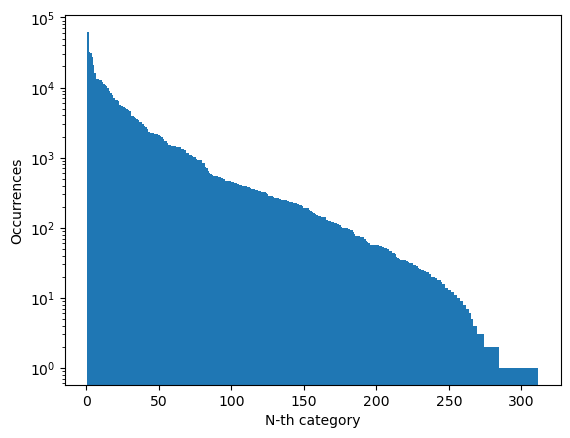

In [44]:
plot_hist_from_value_counts(recipes_food_com, "RecipeCategory", item_name = "category")

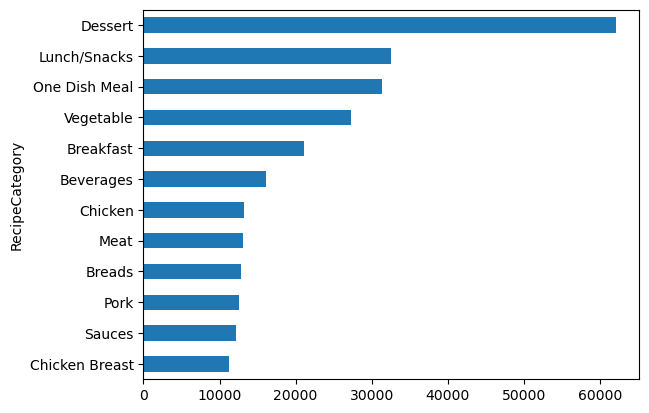

In [45]:
recipes_food_com.RecipeCategory.value_counts(ascending = True)[-12:].plot(kind="barh")
plt.show()

We are still not sure weather we will use Categories as real categorical variable (probably not), so we keep the column as a string and will process it later.

We start exploring list columns one by one, first Recipe Ingredients:

In [46]:
print_values_in_first_n_rows(recipes_food_com, "RecipeIngredientParts", is_list = True)

blueberries, granulated sugar, vanilla yogurt, lemon juice

saffron, milk, hot green chili peppers, onions, garlic, clove, peppercorns, cardamom seed, cumin seed, poppy seed, mace, cilantro, mint leaf, fresh lemon juice, plain yogurt, boneless chicken, salt, ghee, onion, tomatoes, basmati rice, long-grain rice, raisins, cashews, eggs

sugar, lemons, rind of, lemon, zest of, fresh water, fresh lemon juice

extra firm tofu, eggplant, zucchini, mushrooms, soy sauce, low sodium soy sauce, olive oil, maple syrup, honey, red wine vinegar, lemon juice, garlic cloves, mustard powder, black pepper

plain tomato juice, cabbage, onion, carrots, celery



In [47]:
recipes_food_com.RecipeIngredientParts.isna().sum()

2219

In [48]:
recipes_food_com[recipes_food_com.RecipeIngredientParts.isna()].head()

,Name,CookTime,PrepTime,TotalTime,Description,RecipeCategory,Keywords,RecipeIngredientParts,AggregatedRating,ReviewCount,RecipeInstructions
RecipeId,,,,,,,,,,,
412,Frozen Cappuccino,0,10,10,Make and share this Frozen Cappuccino recipe f...,Beverages,"[Very Low Carbs, Low Protein, Low Cholesterol,...",NaN,4.5,3.0,[Place ingredients in blender and blend until ...
808,Iced Coffee II,0,0,0,Make and share this Iced Coffee II recipe from...,Beverages,"[Low Cholesterol, Healthy, < 15 Mins, Refriger...",NaN,NaN,NaN,[Place 1 bag for each 8-10 oz. of unheated wat...
846,Homemade Pop-Tarts,0,0,0,Make and share this Homemade Pop-Tarts recipe ...,Breakfast,"[Dessert, Very Low Carbs, Low Protein, Low Cho...",NaN,4.5,4.0,"[Take pie dough, roll out as usual. Cut into r..."
884,Manifold Roast (Car-b-que),0,0,0,Something to cook on a five- to six-hour car t...,Meat,"[Very Low Carbs, High Protein, High In..., Roa...",NaN,4.0,1.0,"[Start with a 2- to 3-pound roast, the flatter..."
2554,Gold Medal Caramel Bars,25,0,25,Make and share this Gold Medal Caramel Bars re...,Bar Cookie,"[Dessert, Cookie & Brownie, < 30 Mins, Oven, E...",NaN,3.0,2.0,"[Preheat oven to 350°., Prepare a 9 x 13 pan w..."


From what we see there are 2219  of recipes with missing ingredients. Since we assume since we expect this column to be the most important predictor and a recipe without ingredients (at least one) does not make much sense, we drop them.

In [49]:
recipes_food_com = recipes_food_com.dropna(subset = ["RecipeIngredientParts"])

In [50]:
recipes_food_com.RecipeIngredientParts.isna().sum()

0

We make a list with all occurrences of ingredients in the RecipeIngredientParts column and count them:

In [51]:
ingredients_food_com = item_occurences_lst(recipes_food_com, "RecipeIngredientParts")

In [52]:
ingredient_counter = Counter(ingredients_food_com)

In [53]:
len(ingredient_counter) 

7917

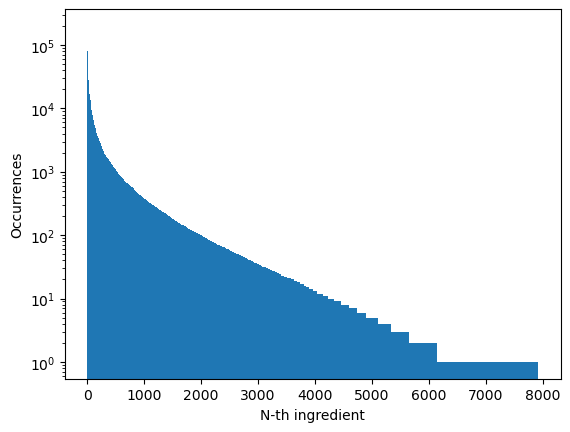

In [54]:
plot_hist_from_counter_object(ingredient_counter)

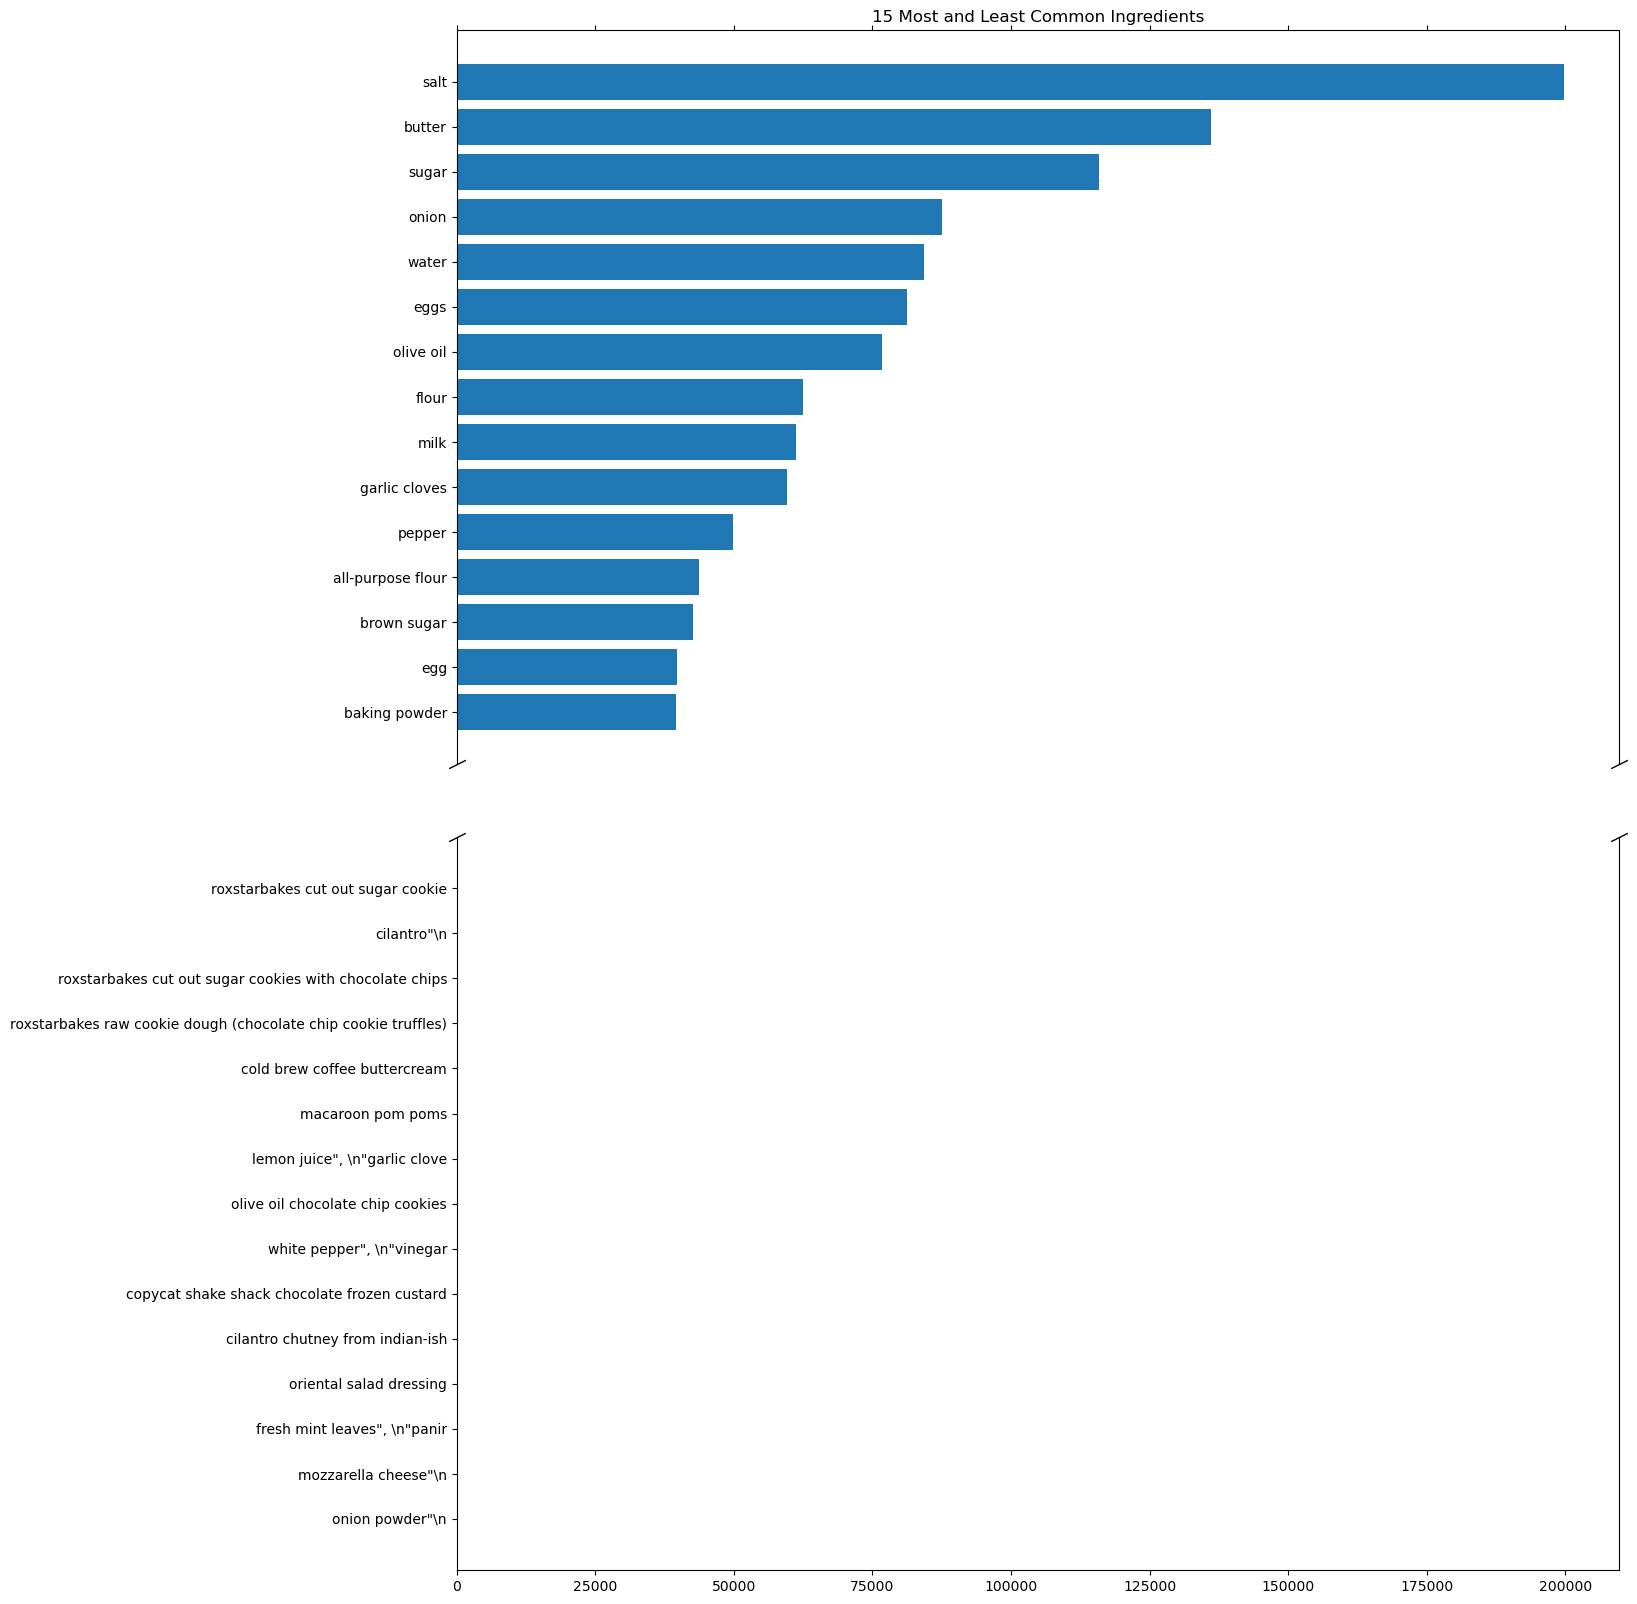

In [55]:
plot_first_last_n_from_counter_object(ingredient_counter, n = 15)

Almost half the recipes contain salt, one third contain butter. There are multiple ingredients with different names that are basically the same thing - like garlic and garlic cloves in the 20 most common. Other problem is the huge number of single occurrences - some spelling errors, bad parsing artifacts (like new lines as part of the string),  weirdly specific ingredients - probably brand names or links to another recipe.
These problems will be addressed later in this work, after we merge all our datasets.

In [56]:
ingredients_chars = [character for ingredient in ingredients_food_com for character in ingredient] # flattened list of all character occurrences

In [57]:
character_counter_ingredients_food_com = Counter(ingredients_chars)

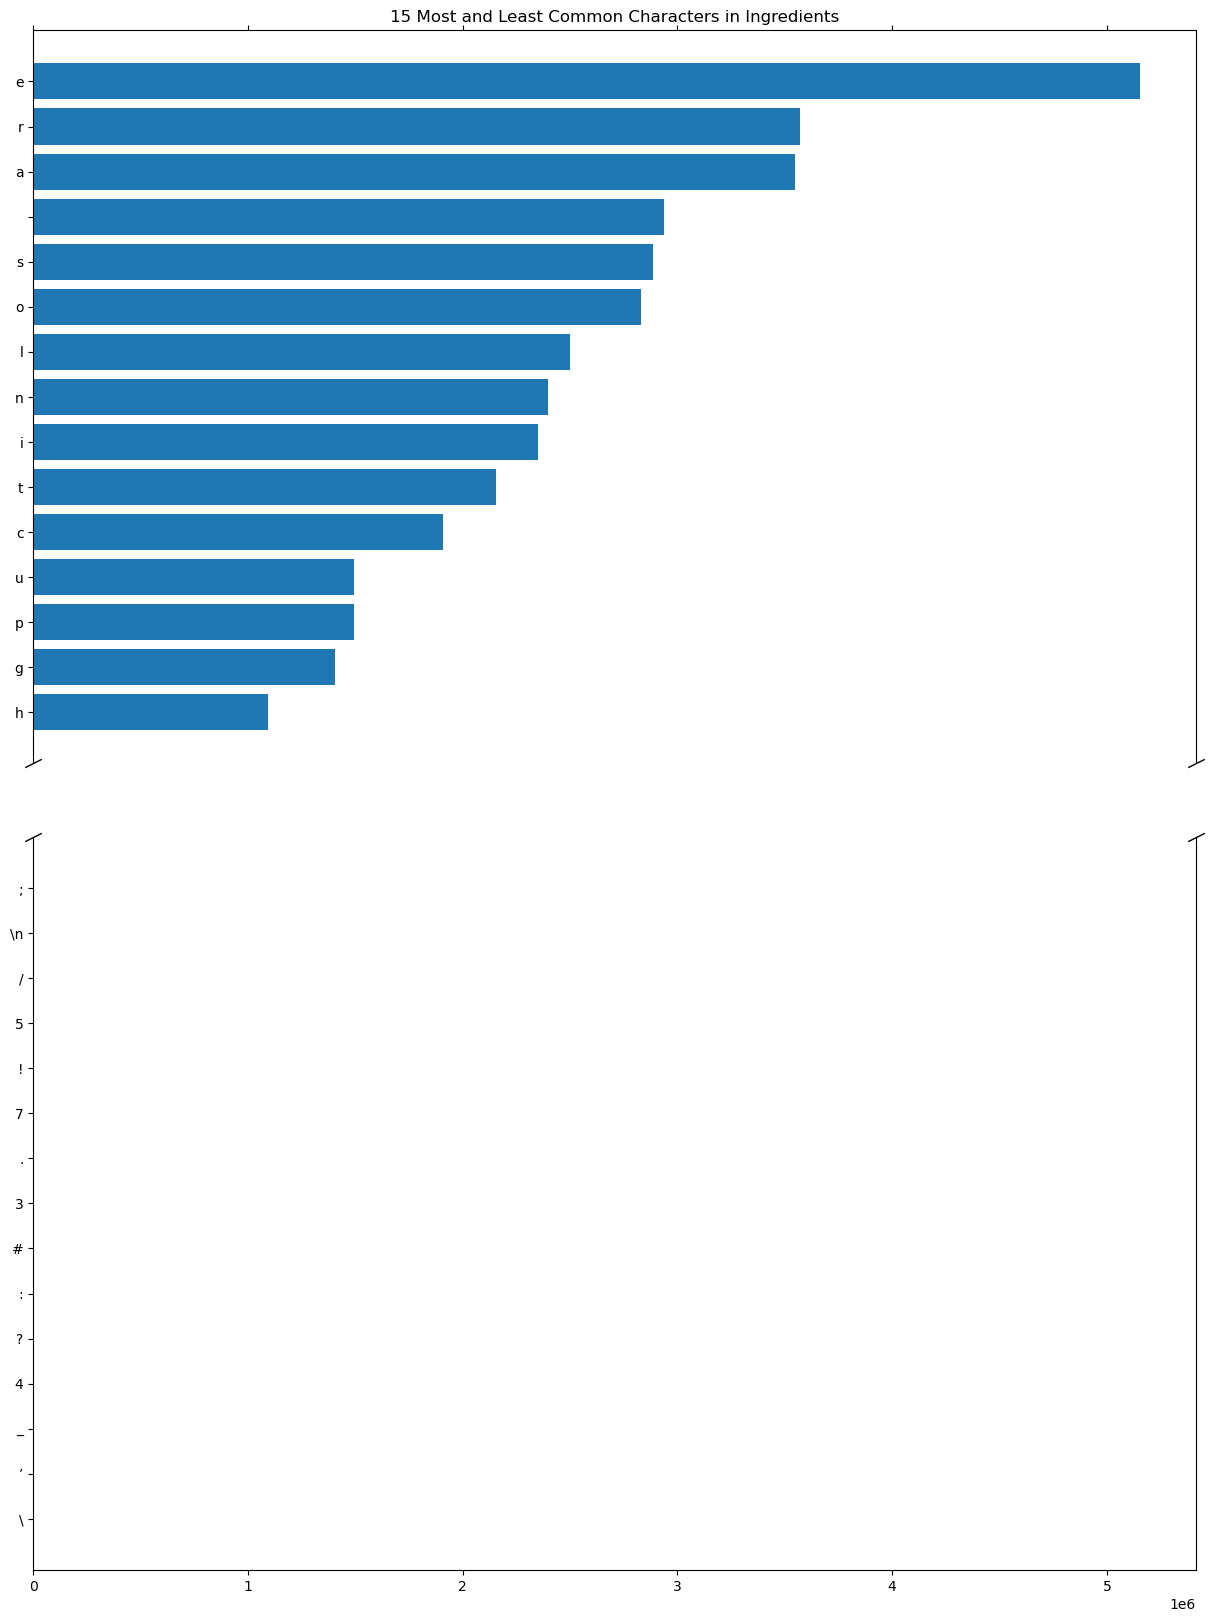

In [59]:
plot_first_last_n_from_counter_object(character_counter_ingredients_food_com, n = 15, item_name = "Characters in Ingredients")

Interesting thing we observe is that most common characters differ from expected. Wchich is not suprising actually, list of ingrethients is not a text, there are no this and thats and the-s, so seing the "t" and "h" way down in top 15 makes sence.

We extract the count of ingredients in the recipe in a new column, as it is descriptive of it's complexity and save the ingredients as a single string.

In [60]:
recipes_food_com["ingredients_count"] = recipes_food_com.RecipeIngredientParts.apply(len)

In [61]:
(recipes_food_com.ingredients_count == 0).sum()

0

In [62]:
recipes_food_com.ingredients_count.isna().sum()

0

In [63]:
recipes_food_com.RecipeIngredientParts = recipes_food_com.RecipeIngredientParts.str.join(", ")

In [64]:
recipes_food_com.head(3)

,Name,CookTime,PrepTime,TotalTime,Description,RecipeCategory,Keywords,RecipeIngredientParts,AggregatedRating,ReviewCount,RecipeInstructions,ingredients_count
RecipeId,,,,,,,,,,,,
38,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,Make and share this Low-Fat Berry Blue Frozen ...,Frozen Desserts,"[Dessert, Low Protein, Low Cholesterol, Health...","blueberries, granulated sugar, vanilla yogurt,...",4.5,4.0,"[Toss 2 cups berries with sugar., Let stand fo...",4
39,Biryani,25,240,265,Make and share this Biryani recipe from Food.com.,Chicken Breast,"[Chicken Thigh & Leg, Chicken, Poultry, Meat, ...","saffron, milk, hot green chili peppers, onions...",3.0,1.0,[Soak saffron in warm milk for 5 minutes and p...,25
40,Best Lemonade,5,30,35,This is from one of my first Good House Keepi...,Beverages,"[Low Protein, Low Cholesterol, Healthy, Summer...","sugar, lemons, rind of, lemon, zest of, fresh ...",4.5,10.0,"[Into a 1 quart Jar with tight fitting lid, pu...",5


Same approach with the RecipeInstructions column - extract the count as unit of complexity and keep all instriction as single string:

In [65]:
(recipes_food_com.RecipeInstructions.isna()).sum()

1

In [66]:
recipes_food_com[recipes_food_com.RecipeInstructions.isna()]

,Name,CookTime,PrepTime,TotalTime,Description,RecipeCategory,Keywords,RecipeIngredientParts,AggregatedRating,ReviewCount,RecipeInstructions,ingredients_count
RecipeId,,,,,,,,,,,,
75934,Collards,60,15,75,Make and share this Collards recipe from Food....,Collard Greens,"[Greens, Vegetable, Low Protein, Low Cholester...","tomatoes, red onion, garlic, honey, Tabasco sa...",NaN,NaN,NaN,6


We find a single recipe with no instructions. Since all other fields are valid and we expect more missing instructions in the other dataset we decide to keep it. For replacing the missing value we use the ingredients as a single string, so resulting complexity is 1 (as "put evereyting in a bow and mix" - 1 step) and we expect the ingredients to be repeated in all other instructions while explaining what when to add. We split by ";" - a charachter we know is not inside the string, so that we convert the string to single item in a list.

In [67]:
recipes_food_com.loc[recipes_food_com.RecipeInstructions.isna(), "RecipeInstructions"] = recipes_food_com.RecipeIngredientParts[recipes_food_com.RecipeInstructions.isna()].str.split(";")

In [68]:
recipes_food_com["instructions_count"] = recipes_food_com.RecipeInstructions.apply(len)

In [69]:
recipes_food_com.RecipeInstructions = recipes_food_com.RecipeInstructions.str.join(" ") # No coma these are full sentences

In [70]:
recipes_food_com.head(2)

,Name,CookTime,PrepTime,TotalTime,Description,RecipeCategory,Keywords,RecipeIngredientParts,AggregatedRating,ReviewCount,RecipeInstructions,ingredients_count,instructions_count
RecipeId,,,,,,,,,,,,,
38,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,Make and share this Low-Fat Berry Blue Frozen ...,Frozen Desserts,"[Dessert, Low Protein, Low Cholesterol, Health...","blueberries, granulated sugar, vanilla yogurt,...",4.5,4.0,Toss 2 cups berries with sugar. Let stand for ...,4,8
39,Biryani,25,240,265,Make and share this Biryani recipe from Food.com.,Chicken Breast,"[Chicken Thigh & Leg, Chicken, Poultry, Meat, ...","saffron, milk, hot green chili peppers, onions...",3.0,1.0,Soak saffron in warm milk for 5 minutes and pu...,25,9


We check the replaced value and make sure the instructions count is 1 (and not the number of chars in the string)

In [73]:
recipes_food_com[recipes_food_com.index == 75934]

,Name,CookTime,PrepTime,TotalTime,Description,RecipeCategory,Keywords,RecipeIngredientParts,AggregatedRating,ReviewCount,RecipeInstructions,ingredients_count,instructions_count
RecipeId,,,,,,,,,,,,,
75934,Collards,60,15,75,Make and share this Collards recipe from Food....,Collard Greens,"[Greens, Vegetable, Low Protein, Low Cholester...","tomatoes, red onion, garlic, honey, Tabasco sa...",NaN,NaN,"tomatoes, red onion, garlic, honey, Tabasco sa...",6,1


In [74]:
assert int(recipes_food_com.loc[75934, "instructions_count"]) == 1

Next - the keywords column:

In [75]:
print_values_in_first_n_rows(recipes_food_com, "Keywords", is_list = True)

Dessert, Low Protein, Low Cholesterol, Healthy, Free Of..., Summer, Weeknight, Freezer, Easy

Chicken Thigh & Leg, Chicken, Poultry, Meat, Asian, Indian, Weeknight, Stove Top

Low Protein, Low Cholesterol, Healthy, Summer, < 60 Mins

Beans, Vegetable, Low Cholesterol, Weeknight, Broil/Grill, Oven

Low Protein, Vegan, Low Cholesterol, Healthy, Winter, < 60 Mins, Easy



In [76]:
keywords = item_occurences_lst(recipes_food_com, "Keywords")

In [77]:
keywords_counter = Counter(keywords)

In [78]:
len(keywords_counter)

315

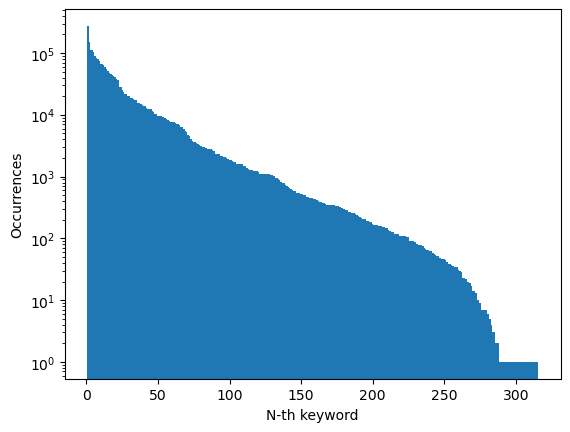

In [79]:
plot_hist_from_counter_object(keywords_counter, item_name="keyword")

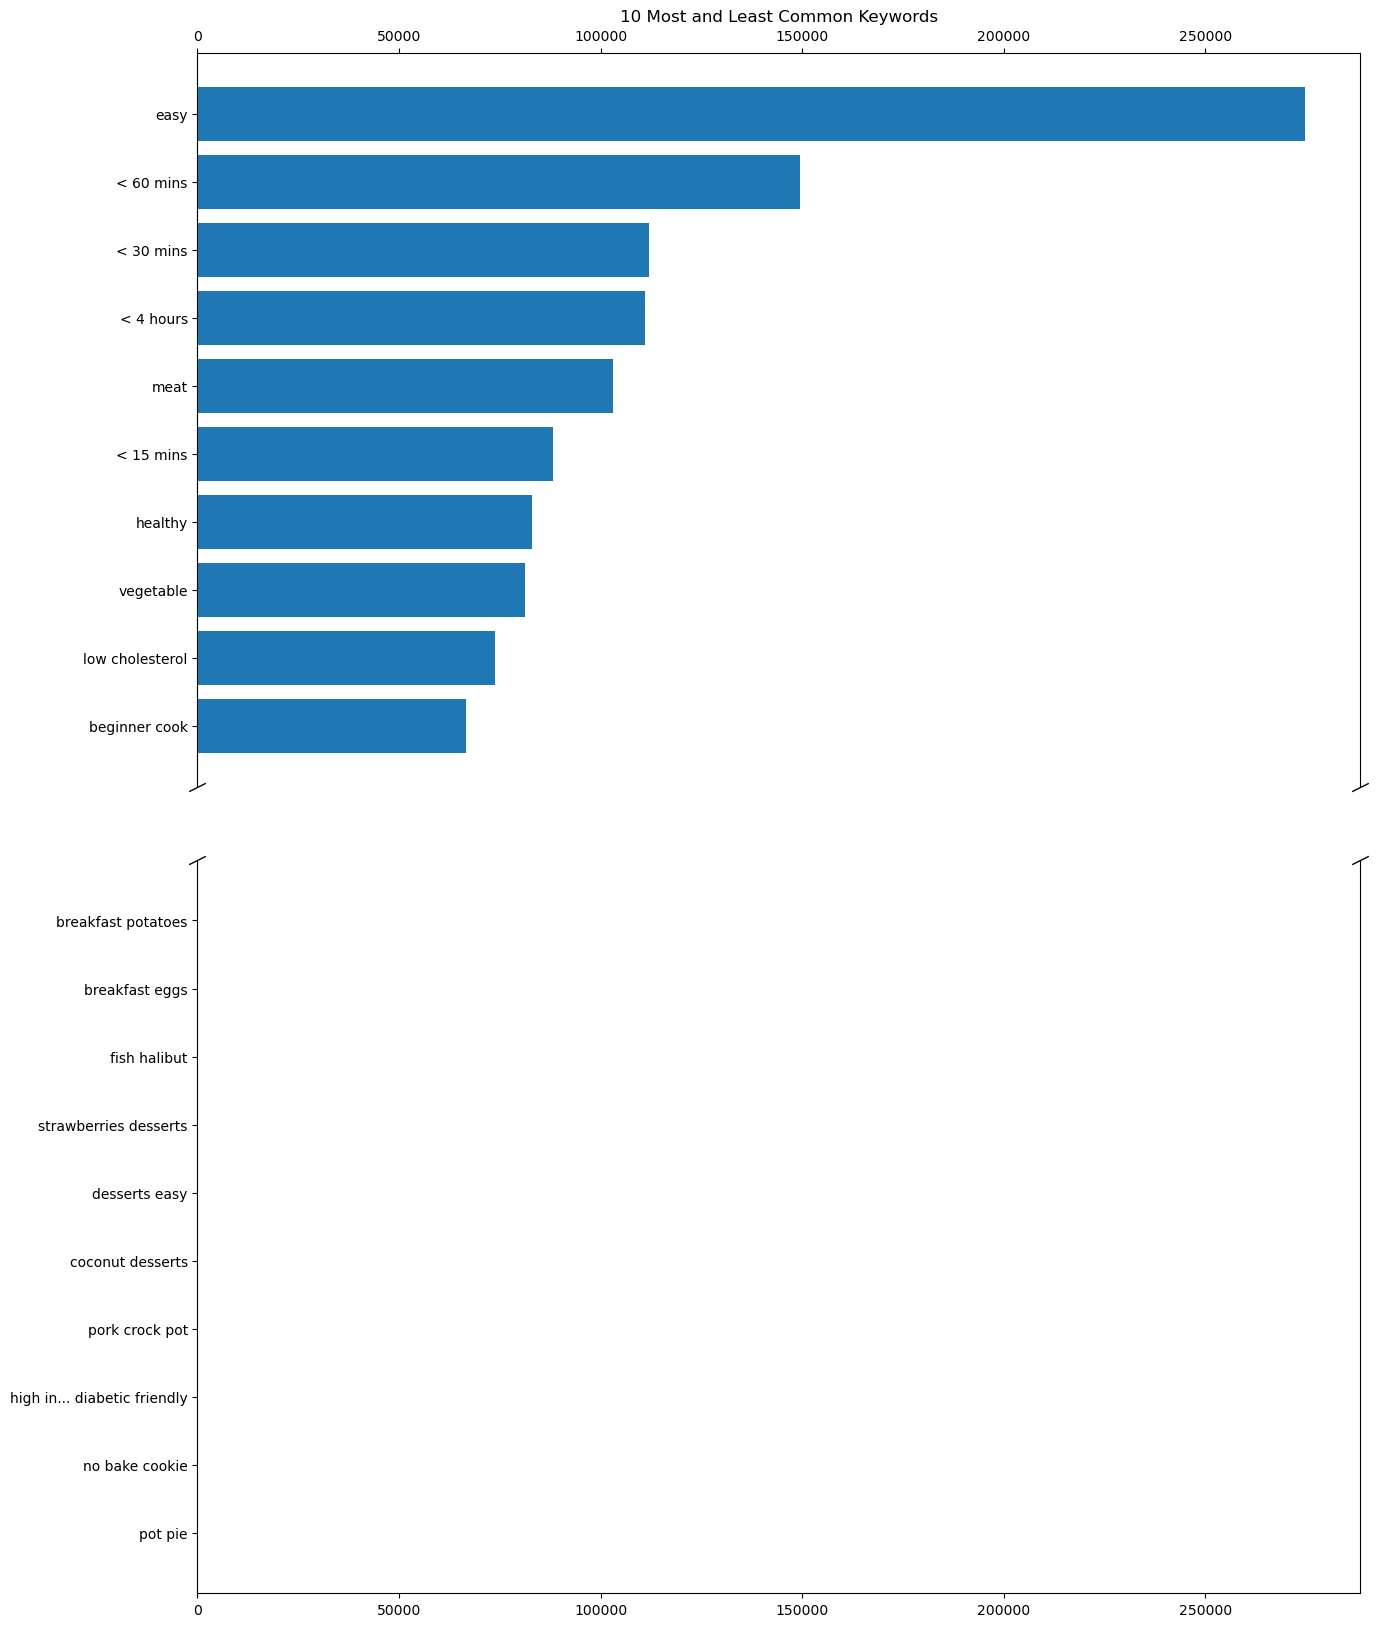

In [82]:
plot_first_last_n_from_counter_object(keywords_counter, item_name="Keywords")

Well, it looks like every second recipe is easy and pot pies are not as popular as i thought :) On a more serious note, we decide to keep only concatenated string of all key_words, since we find no information in their count or order.

In [83]:
recipes_food_com.Keywords = recipes_food_com.Keywords.str.join(", ")

In [84]:
recipes_food_com.Keywords.apply(lambda x: type(x)).unique()

array([<class 'str'>, <class 'float'>], dtype=object)

As expected we have strings and floats(because of the NaN values), and no lists.

Final look (for now) at the dataset:

In [85]:
recipes_food_com

,Name,CookTime,PrepTime,TotalTime,Description,RecipeCategory,Keywords,RecipeIngredientParts,AggregatedRating,ReviewCount,RecipeInstructions,ingredients_count,instructions_count
RecipeId,,,,,,,,,,,,,
38,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,Make and share this Low-Fat Berry Blue Frozen ...,Frozen Desserts,"Dessert, Low Protein, Low Cholesterol, Healthy...","blueberries, granulated sugar, vanilla yogurt,...",4.5,4.0,Toss 2 cups berries with sugar. Let stand for ...,4,8
39,Biryani,25,240,265,Make and share this Biryani recipe from Food.com.,Chicken Breast,"Chicken Thigh & Leg, Chicken, Poultry, Meat, A...","saffron, milk, hot green chili peppers, onions...",3.0,1.0,Soak saffron in warm milk for 5 minutes and pu...,25,9
40,Best Lemonade,5,30,35,This is from one of my first Good House Keepi...,Beverages,"Low Protein, Low Cholesterol, Healthy, Summer,...","sugar, lemons, rind of, lemon, zest of, fresh ...",4.5,10.0,"Into a 1 quart Jar with tight fitting lid, put...",5,5
41,Carina's Tofu-Vegetable Kebabs,20,1440,1460,This dish is best prepared a day in advance to...,Soy/Tofu,"Beans, Vegetable, Low Cholesterol, Weeknight, ...","extra firm tofu, eggplant, zucchini, mushrooms...",4.5,2.0,"Drain the tofu, carefully squeezing out excess...",14,13
42,Cabbage Soup,30,20,50,Make and share this Cabbage Soup recipe from F...,Vegetable,"Low Protein, Vegan, Low Cholesterol, Healthy, ...","plain tomato juice, cabbage, onion, carrots, c...",4.5,11.0,Mix everything together and bring to a boil. R...,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541379,Meg's Fresh Ginger Gingerbread,35,60,95,Make and share this Meg's Fresh Ginger Gingerb...,Dessert,< 4 Hours,"fresh ginger, unsalted butter, dark brown suga...",NaN,NaN,Preheat oven to 350&deg;F Grease an 8x8 cake p...,12,8
541380,Roast Prime Rib au Poivre with Mixed Peppercorns,180,30,210,"White, black, green, and pink peppercorns add ...",Very Low Carbs,"High Protein, High In..., < 4 Hours","Dijon mustard, garlic, peppercorns, shallot, c...",NaN,NaN,Position rack in center of oven and preheat to...,6,3
541381,Kirshwasser Ice Cream,180,60,240,Make and share this Kirshwasser Ice Cream reci...,Ice Cream,"Dessert, < 4 Hours","half-and-half, heavy cream, brandy, sugar",NaN,NaN,heat half and half and heavy cream to a simmer...,4,4


In [86]:
recipes_food_com.dtypes

Name                      object
CookTime                   int32
PrepTime                   int32
TotalTime                  int32
Description               object
RecipeCategory            object
Keywords                  object
RecipeIngredientParts     object
AggregatedRating         float64
ReviewCount              float64
RecipeInstructions        object
ingredients_count          int64
instructions_count         int64
dtype: object

In [87]:
recipes_food_com.describe().T

,count,mean,std,min,25%,50%,75%,max
CookTime,520230.0,197.767568,62426.543539,0.0,10.0,20.0,45.0,43545600.0
PrepTime,520230.0,55.200396,3015.363777,0.0,10.0,15.0,20.0,1440000.0
TotalTime,520230.0,253.039759,62532.743369,0.0,20.0,40.0,70.0,43552800.0
AggregatedRating,268226.0,4.631719,0.642040,1.0,4.5,5.0,5.0,5.0
ReviewCount,273940.0,5.228097,20.393984,1.0,1.0,2.0,4.0,3063.0
ingredients_count,520230.0,7.936524,3.919933,1.0,5.0,8.0,10.0,43.0
instructions_count,520230.0,6.161142,3.833951,1.0,4.0,5.0,8.0,95.0


<a id="datasets_two"></a>
### 2.1. Allrecipes.com - foodRecSys-V1

Another dataset publicly available at [kaggle.com](https://www.kaggle.com/datasets/elisaxxygao/foodrecsysv1). Containes data for almost 50 000 recipes posted between 2000 and 2018 on Allrecipes.com. Features include recipe name, ingredients, directions, nutrition, image and the corresponding ratings from users.

In [129]:
recipes_allrecipes_com = pd.read_csv("data/foodRecSys-V1_kaggle/core-data_recipe.csv")

In [130]:
recipes_allrecipes_com.head()

,recipe_id,recipe_name,image_url,ingredients,cooking_directions,nutritions
0,240488,"Pork Loin, Apples, and Sauerkraut",https://images.media-allrecipes.com/userphotos...,sauerkraut drained^Granny Smith apples sliced^...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name..."
1,218939,Foolproof Rosemary Chicken Wings,https://images.media-allrecipes.com/userphotos...,chicken wings^sprigs rosemary^head garlic^oliv...,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'..."
2,87211,Chicken Pesto Paninis,https://images.media-allrecipes.com/userphotos...,focaccia bread quartered^prepared basil pesto^...,{'directions': u'Prep\n15 m\nCook\n5 m\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
3,245714,Potato Bacon Pizza,https://images.media-allrecipes.com/userphotos...,red potatoes^strips bacon^Sauce:^heavy whippin...,{'directions': u'Prep\n20 m\nCook\n45 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
4,218545,Latin-Inspired Spicy Cream Chicken Stew,https://images.media-allrecipes.com/userphotos...,skinless boneless chicken breast halves^diced ...,{'directions': u'Prep\n10 m\nCook\n8 h 15 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name..."


In [131]:
recipes_allrecipes_com.shape

(45630, 6)

In [132]:
recipes_allrecipes_com.dtypes

recipe_id              int64
recipe_name           object
image_url             object
ingredients           object
cooking_directions    object
nutritions            object
dtype: object

Again, we make sure there are no duplicate values in the "recipe_id" column and set it as the index of the dataframe:

In [133]:
assert(len(recipes_allrecipes_com.recipe_id.unique()) == recipes_allrecipes_com.shape[0])

In [134]:
recipes_allrecipes_com = recipes_allrecipes_com.set_index("recipe_id")

In [135]:
print_values_in_first_n_rows(recipes_allrecipes_com, "nutritions", n = 1)

{u'niacin': {u'hasCompleteData': False, u'name': u'Niacin Equivalents', u'amount': 15.6016, u'percentDailyValue': u'120', u'displayValue': u'16', u'unit': u'mg'}, u'sugars': {u'hasCompleteData': False, u'name': u'Sugars', u'amount': 19.84146, u'percentDailyValue': u'0', u'displayValue': u'19.8', u'unit': u'g'}, u'sodium': {u'hasCompleteData': False, u'name': u'Sodium', u'amount': 2606.764, u'percentDailyValue': u'104', u'displayValue': u'2607', u'unit': u'mg'}, u'carbohydrates': {u'hasCompleteData': True, u'name': u'Carbohydrates', u'amount': 32.08176, u'percentDailyValue': u'10', u'displayValue': u'32.1', u'unit': u'g'}, u'vitaminB6': {u'hasCompleteData': False, u'name': u'Vitamin B6', u'amount': 1.328631, u'percentDailyValue': u'83', u'displayValue': u'1', u'unit': u'mg'}, u'calories': {u'hasCompleteData': True, u'name': u'Calories', u'amount': 371.7219, u'percentDailyValue': u'19', u'displayValue': u'372', u'unit': u'kcal'}, u'thiamin': {u'hasCompleteData': False, u'name': u'Thiamin

As already stated, nutrition is out of the scope of the current work, so we exclude the column from our dataframe:

In [136]:
recipes_allrecipes_com = recipes_allrecipes_com.drop(columns = ["nutritions"])

Again, we separate the images as metadata:

In [137]:
recipes_allrecipes_com_meta = recipes_allrecipes_com.image_url
recipes_allrecipes_com_meta

recipe_id
240488    https://images.media-allrecipes.com/userphotos...
218939    https://images.media-allrecipes.com/userphotos...
87211     https://images.media-allrecipes.com/userphotos...
245714    https://images.media-allrecipes.com/userphotos...
218545    https://images.media-allrecipes.com/userphotos...
                                ...                        
222886    https://images.media-allrecipes.com/userphotos...
25650     https://images.media-allrecipes.com/userphotos...
23544     https://images.media-allrecipes.com/userphotos...
170710    https://images.media-allrecipes.com/userphotos...
79774     https://images.media-allrecipes.com/userphotos...
Name: image_url, Length: 45630, dtype: object

In [138]:
recipes_allrecipes_com = recipes_allrecipes_com.drop(columns = ["image_url"])

Exploring ingredients column:

In [139]:
print_values_in_first_n_rows(recipes_allrecipes_com, "ingredients")

sauerkraut drained^Granny Smith apples sliced^large onion^caraway seeds^apple cider divided^brown sugar^Rub:^Thai seasoning^salt^garlic powder^ground black pepper^boneless pork loin roast

chicken wings^sprigs rosemary^head garlic^olive oil^lemon pepper^seasoned salt

focaccia bread quartered^prepared basil pesto^diced cooked chicken^diced green bell pepper^diced red onion^shredded Monterey Jack cheese

red potatoes^strips bacon^Sauce:^heavy whipping cream^butter^minced garlic^grated Parmesan cheese^Crust:^warm water (125 degrees F 52 degrees C)^honey^active dry yeast^vegetable oil^all-purpose flour^shredded mozzarella cheese

skinless boneless chicken breast halves^diced tomatoes^green salsa^black beans rinsed and drained^pinto beans drained and rinsed^kernel corn^taco seasoning^chopped fresh cilantro^ground red chile pepper^ground cumin^cream cheese



In [140]:
recipes_allrecipes_com.ingredients.isna().sum() # No missing values

0

Here we see that the ingredients names contain descriptions and snippets of cooking instructions - "skinless boneless chicken breast halves", "black beans rinsed and drained", "diced tomatoes", which makes counting the unique values pointless. The count of ingredients in a single recipe describes it's complexity, so we save it in a new column "ingredient_count". Replace annoying "^" symbols and keep the ingredients as string.

In [141]:
recipes_allrecipes_com.ingredients = recipes_allrecipes_com.ingredients.str.split("^")

In [142]:
recipes_allrecipes_com["ingredients_count"] = np.where(recipes_allrecipes_com.ingredients.isna(), np.NaN, recipes_allrecipes_com.ingredients.apply(len))

In [143]:
recipes_allrecipes_com.ingredients = recipes_allrecipes_com.ingredients.str.join(", ")

In [151]:
recipes_allrecipes_com.ingredients_count = recipes_allrecipes_com.ingredients_count.astype("int")

In [153]:
recipes_allrecipes_com.ingredients_count.isna().sum()

0

In [154]:
recipes_allrecipes_com

,recipe_name,ingredients,cooking_directions,ingredients_count
recipe_id,,,,
240488,"Pork Loin, Apples, and Sauerkraut","sauerkraut drained, Granny Smith apples sliced...",{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,12
218939,Foolproof Rosemary Chicken Wings,"chicken wings, sprigs rosemary, head garlic, o...","{'directions': u""Prep\n20 m\nCook\n40 m\nReady...",6
87211,Chicken Pesto Paninis,"focaccia bread quartered, prepared basil pesto...",{'directions': u'Prep\n15 m\nCook\n5 m\nReady ...,6
245714,Potato Bacon Pizza,"red potatoes, strips bacon, Sauce:, heavy whip...",{'directions': u'Prep\n20 m\nCook\n45 m\nReady...,14
218545,Latin-Inspired Spicy Cream Chicken Stew,"skinless boneless chicken breast halves, diced...",{'directions': u'Prep\n10 m\nCook\n8 h 15 m\nR...,11
...,...,...,...,...
222886,Grateful Dead Cocktail,"fluid ounce tequila, fluid ounce vodka, fluid ...",{'directions': u'Prep\n5 m\nReady In\n5 m\nCom...,7
25650,Cheese Filling For Pastries,"raisins, brandy, cream cheese, white sugar, al...",{'directions': u'Prep\n15 m\nReady In\n15 m\nS...,9
23544,Peach Smoothie,"sliced peaches drained, scoops vanilla ice cre...",{'directions': u'Prep\n1 m\nReady In\n1 m\nIn ...,4


Cooking directions column:

In [156]:
recipes_allrecipes_com.cooking_directions[240488]
print_values_in_first_n_rows(recipes_allrecipes_com, "cooking_directions", n = 2)

{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nReady In\n2 h 45 m\nPreheat oven to 325 degrees F (165 degrees C).\nMix sauerkraut, apples, onion, and caraway seeds in a large roasting pan. Stir 1/4 cup apple cider and brown sugar together in a separate bowl; pour over sauerkraut mixture.\nStir Thai seasoning, salt, garlic powder, and black pepper together in a small bowl; rub onto the top and bottom of the roast.\nMake an indentation in the center of the sauerkraut mixture and place the seasoned roast in the indentation. Pour the remaining apple cider around the roast.\nBake in the preheated oven for 1 hour; baste roast with juices. Continue baking roast, basting every 30 minutes, until cooked through, 2 1/2 to 3 hours. An instant-read thermometer inserted into the center should read at least 145 degrees F (63 degrees C).'}

{'directions': u"Prep\n20 m\nCook\n40 m\nReady In\n1 h\nPreheat an oven to 350 degrees F (175 degrees C).\nArrange the chicken wings, rosemary, and garlic cloves on 

In [157]:
recipes_allrecipes_com[recipes_allrecipes_com.cooking_directions.isna()]

,recipe_name,ingredients,cooking_directions,ingredients_count
recipe_id,,,,


There are no missing values. We can extract various information from this column - Prep time, Cook time and Total time; text of the instructions. Since they are not separated by steps, we take sentence count as measure for instructions complexity.

In [159]:
recipes_allrecipes_com["time"] = recipes_allrecipes_com.cooking_directions.str.extract(r'\'directions\': u(.*[mh])\\n')

In [160]:
recipes_allrecipes_com.time

recipe_id
240488    'Prep\n15 m\nCook\n2 h 30 m\nReady In\n2 h 45 m
218939             "Prep\n20 m\nCook\n40 m\nReady In\n1 h
87211              'Prep\n15 m\nCook\n5 m\nReady In\n20 m
245714        'Prep\n20 m\nCook\n45 m\nReady In\n1 h 10 m
218545    'Prep\n10 m\nCook\n8 h 15 m\nReady In\n8 h 25 m
                               ...                       
222886                          'Prep\n5 m\nReady In\n5 m
25650                         'Prep\n15 m\nReady In\n15 m
23544                           'Prep\n1 m\nReady In\n1 m
170710            'Prep\n20 m\nCook\n10 m\nReady In\n30 m
79774             'Prep\n15 m\nCook\n40 m\nReady In\n55 m
Name: time, Length: 45630, dtype: object

In [161]:
recipes_no_times = recipes_allrecipes_com.time.isna().sum()
recipes_no_times

4865

In [162]:
recipes_allrecipes_com[recipes_allrecipes_com.time.isna()]

,recipe_name,ingredients,cooking_directions,ingredients_count,time
recipe_id,,,,,
8987,Cheesy Chicken and Potato Casserole,"vegetable oil, skinless boneless chicken breas...",{'directions': u'Preheat oven to 350 degrees F...,5,NaN
8657,Julie's Chicken Salad,"skinless boneless chicken breast halves, raisi...",{'directions': u'In a large bowl toss together...,9,NaN
9035,Becki's Oven Barbecue Chicken,"chicken wings, butter, onion powder, brown sug...",{'directions': u'Preheat oven to 425 degrees F...,8,NaN
156795,Barbeque Chicken Pasagna,"olive oil, skinless boneless chicken breast ha...",{'directions': u'Preheat oven to 400 degrees F...,10,NaN
182157,Smoked Paprika Goulash for the Slow Cooker,"vegetable oil, onions, garlic, smoked Spanish ...",{'directions': u'Heat 1 tablespoon oil in a la...,13,NaN
...,...,...,...,...,...
77937,Creamy Corn With Cumin Soup,"olive oil, frozen corn, large onion, butter, s...","{'directions': u""Heat oil over medium-high hea...",13,NaN
10551,Festive Cherrettes,"shortening, butter, salt, confectioners' sugar...","{'directions': u'Blend together shortening, bu...",8,NaN
13143,Cream of Artichoke Soup I,"artichokes, water, chicken stock, dry vermouth...","{'directions': u""Steam the artichokes in 2 cup...",15,NaN


We see that there are directions with no times. Whether this is the case for all 4865 missing values is not sure, but we leave it as it is and continue working.
We remove the content of the "time" column from "cooking_directions", since it is no longer needed there.

In [166]:
recipes_allrecipes_com.time = recipes_allrecipes_com.time.fillna("") # replace Nans with empty string

In [106]:
# recipes_allrecipes_com.cooking_directions = recipes_allrecipes_com.apply(lambda x: x.cooking_directions.replace(x.time, ""), axis = 1)

In [168]:
# remove the string in "time" column from the string in "directions" column
recipes_allrecipes_com.cooking_directions = recipes_allrecipes_com.cooking_directions.str.replace(
    "{\'directions\': u\\n", "", regex = False, case = False
).str.strip("}") # bah, that's ugly, sorry

In [169]:
recipes_allrecipes_com["instructions_count"] = recipes_allrecipes_com.cooking_directions.str.split(r'\\n').apply(len)

In [170]:
recipes_allrecipes_com.cooking_directions = recipes_allrecipes_com.cooking_directions.str.split(r'\\n').str.join(" ")

In [171]:
recipes_allrecipes_com.head(3)

,recipe_name,ingredients,cooking_directions,ingredients_count,time,instructions_count
recipe_id,,,,,,
240488,"Pork Loin, Apples, and Sauerkraut","sauerkraut drained, Granny Smith apples sliced...",{'directions': u'Prep 15 m Cook 2 h 30 m Ready...,12,'Prep\n15 m\nCook\n2 h 30 m\nReady In\n2 h 45 m,11
218939,Foolproof Rosemary Chicken Wings,"chicken wings, sprigs rosemary, head garlic, o...","{'directions': u""Prep 20 m Cook 40 m Ready In ...",6,"""Prep\n20 m\nCook\n40 m\nReady In\n1 h",11
87211,Chicken Pesto Paninis,"focaccia bread quartered, prepared basil pesto...",{'directions': u'Prep 15 m Cook 5 m Ready In 2...,6,'Prep\n15 m\nCook\n5 m\nReady In\n20 m,9


Continue with on extracting numeral values from the time string.

In [172]:
for new_column, pattern in [("time_total", r'Ready In\\n(.*[mh])'), ("time_cook", r'Cook\\n(.*[mh])'), ("time_prep", r'Prep\\n(.*[mh])')]:
    recipes_allrecipes_com[new_column] = recipes_allrecipes_com.time.str.extract(pattern)
    recipes_allrecipes_com.time = recipes_allrecipes_com.time.str.replace(pat=pattern, repl="", regex = True)


    hours = recipes_allrecipes_com[new_column].str.extract('(\d*) h')
    hours[hours.isna()] = 0
    hours[hours == ""] = 0
    hours = hours.astype("int") # int because the regex pattern will not match a float anyway

    minutes = recipes_allrecipes_com[new_column].str.extract('(\d*) m')
    minutes[minutes.isna()] = 0
    minutes = minutes.astype("int")

    recipes_allrecipes_com[new_column] = hours * 60 + minutes
    
    

In [173]:
recipes_allrecipes_com = recipes_allrecipes_com.drop(columns=["time"])

In [174]:
recipes_allrecipes_com 

,recipe_name,ingredients,cooking_directions,ingredients_count,instructions_count,time_total,time_cook,time_prep
recipe_id,,,,,,,,
240488,"Pork Loin, Apples, and Sauerkraut","sauerkraut drained, Granny Smith apples sliced...",{'directions': u'Prep 15 m Cook 2 h 30 m Ready...,12,11,165,150,15
218939,Foolproof Rosemary Chicken Wings,"chicken wings, sprigs rosemary, head garlic, o...","{'directions': u""Prep 20 m Cook 40 m Ready In ...",6,11,60,40,20
87211,Chicken Pesto Paninis,"focaccia bread quartered, prepared basil pesto...",{'directions': u'Prep 15 m Cook 5 m Ready In 2...,6,9,20,5,15
245714,Potato Bacon Pizza,"red potatoes, strips bacon, Sauce:, heavy whip...",{'directions': u'Prep 20 m Cook 45 m Ready In ...,14,14,70,45,20
218545,Latin-Inspired Spicy Cream Chicken Stew,"skinless boneless chicken breast halves, diced...",{'directions': u'Prep 10 m Cook 8 h 15 m Ready...,11,8,505,495,10
...,...,...,...,...,...,...,...,...
222886,Grateful Dead Cocktail,"fluid ounce tequila, fluid ounce vodka, fluid ...",{'directions': u'Prep 5 m Ready In 5 m Combine...,7,5,5,0,5
25650,Cheese Filling For Pastries,"raisins, brandy, cream cheese, white sugar, al...",{'directions': u'Prep 15 m Ready In 15 m Sprin...,9,6,15,0,15
23544,Peach Smoothie,"sliced peaches drained, scoops vanilla ice cre...",{'directions': u'Prep 1 m Ready In 1 m In a bl...,4,5,1,0,1


We celebrate the victory against regex and nans appearing from thin air and continue to check weather we have lost too many values in the battle:

In [175]:
# pattern_total_time = r'Ready In\\n(.*[mh])'
# recipes_allrecipes_com["time_total"] = recipes_allrecipes_com.time.str.extract(pattern_total_time)
# recipes_allrecipes_com.time = recipes_allrecipes_com.time.str.replace(pat=pattern_total_time, repl="", regex = True)

In [176]:
# pattern_cook_time = r'Cook\\n(.*[mh])'
# recipes_allrecipes_com["time_cook"] = recipes_allrecipes_com.time.str.extract(pattern_cook_time)
# recipes_allrecipes_com.time = recipes_allrecipes_com.time.str.replace(pat=pattern_cook_time, repl="", regex = True)

In [177]:
# pattern_prep_time = r'Prep\\n(.*[mh])'
# recipes_allrecipes_com["time_prep"] = recipes_allrecipes_com.time.str.extract(pattern_prep_time)
# recipes_allrecipes_com = recipes_allrecipes_com.drop(columns=["time"])

In [178]:
(recipes_allrecipes_com.time_prep == 0).sum(), (recipes_allrecipes_com.time_cook == 0).sum(), (recipes_allrecipes_com.time_total == 0).sum()

(5147, 11908, 4884)

In [179]:
recipes_allrecipes_com[(recipes_allrecipes_com.time_prep + recipes_allrecipes_com.time_cook + recipes_allrecipes_com.time_total) == 0]

,recipe_name,ingredients,cooking_directions,ingredients_count,instructions_count,time_total,time_cook,time_prep
recipe_id,,,,,,,,
8987,Cheesy Chicken and Potato Casserole,"vegetable oil, skinless boneless chicken breas...",{'directions': u'Preheat oven to 350 degrees F...,5,3,0,0,0
8657,Julie's Chicken Salad,"skinless boneless chicken breast halves, raisi...",{'directions': u'In a large bowl toss together...,9,1,0,0,0
9035,Becki's Oven Barbecue Chicken,"chicken wings, butter, onion powder, brown sug...",{'directions': u'Preheat oven to 425 degrees F...,8,3,0,0,0
156795,Barbeque Chicken Pasagna,"olive oil, skinless boneless chicken breast ha...",{'directions': u'Preheat oven to 400 degrees F...,10,4,0,0,0
182157,Smoked Paprika Goulash for the Slow Cooker,"vegetable oil, onions, garlic, smoked Spanish ...",{'directions': u'Heat 1 tablespoon oil in a la...,13,6,0,0,0
...,...,...,...,...,...,...,...,...
77937,Creamy Corn With Cumin Soup,"olive oil, frozen corn, large onion, butter, s...","{'directions': u""Heat oil over medium-high hea...",13,7,0,0,0
10551,Festive Cherrettes,"shortening, butter, salt, confectioners' sugar...","{'directions': u'Blend together shortening, bu...",8,3,0,0,0
13143,Cream of Artichoke Soup I,"artichokes, water, chicken stock, dry vermouth...","{'directions': u""Steam the artichokes in 2 cup...",15,6,0,0,0


In [180]:
recipes_no_times

4865

We lost only 2 values and happily continue exploring.

In [181]:
recipes_allrecipes_com

,recipe_name,ingredients,cooking_directions,ingredients_count,instructions_count,time_total,time_cook,time_prep
recipe_id,,,,,,,,
240488,"Pork Loin, Apples, and Sauerkraut","sauerkraut drained, Granny Smith apples sliced...",{'directions': u'Prep 15 m Cook 2 h 30 m Ready...,12,11,165,150,15
218939,Foolproof Rosemary Chicken Wings,"chicken wings, sprigs rosemary, head garlic, o...","{'directions': u""Prep 20 m Cook 40 m Ready In ...",6,11,60,40,20
87211,Chicken Pesto Paninis,"focaccia bread quartered, prepared basil pesto...",{'directions': u'Prep 15 m Cook 5 m Ready In 2...,6,9,20,5,15
245714,Potato Bacon Pizza,"red potatoes, strips bacon, Sauce:, heavy whip...",{'directions': u'Prep 20 m Cook 45 m Ready In ...,14,14,70,45,20
218545,Latin-Inspired Spicy Cream Chicken Stew,"skinless boneless chicken breast halves, diced...",{'directions': u'Prep 10 m Cook 8 h 15 m Ready...,11,8,505,495,10
...,...,...,...,...,...,...,...,...
222886,Grateful Dead Cocktail,"fluid ounce tequila, fluid ounce vodka, fluid ...",{'directions': u'Prep 5 m Ready In 5 m Combine...,7,5,5,0,5
25650,Cheese Filling For Pastries,"raisins, brandy, cream cheese, white sugar, al...",{'directions': u'Prep 15 m Ready In 15 m Sprin...,9,6,15,0,15
23544,Peach Smoothie,"sliced peaches drained, scoops vanilla ice cre...",{'directions': u'Prep 1 m Ready In 1 m In a bl...,4,5,1,0,1


In [182]:
recipes_allrecipes_com.describe().T

,count,mean,std,min,25%,50%,75%,max
ingredients_count,45630.0,9.097436,3.876082,1.0,6.0,9.0,11.0,34.0
instructions_count,45630.0,8.314661,2.641030,1.0,7.0,9.0,10.0,28.0
time_total,45630.0,81.622814,126.521321,0.0,20.0,45.0,80.0,1425.0
time_cook,45630.0,36.618562,73.920318,0.0,0.0,20.0,40.0,1320.0
time_prep,45630.0,15.520995,18.538760,0.0,10.0,15.0,20.0,830.0


<a id="datasets_three"></a>
### 2.3. Epicurious Food Ingredients with images

In [183]:
recipes_epicurious_com = pd.read_csv("data/epicurious_Food_Ingredients_with_images/Food Ingredients and Recipe Dataset with Image Name Mapping.csv")

In [184]:
recipes_epicurious_com

,Unnamed: 0,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400°F and line a rimmed baking...,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (..."
2,2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",Preheat oven to 350°F with rack in middle. Gen...,italian-sausage-and-bread-stuffing-240559,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."
...,...,...,...,...,...,...
13496,13496,Brownie Pudding Cake,"['1 cup all-purpose flour', '2/3 cup unsweeten...",Preheat the oven to 350°F. Into a bowl sift to...,brownie-pudding-cake-14408,"['1 cup all-purpose flour', '2/3 cup unsweeten..."
13497,13497,Israeli Couscous with Roasted Butternut Squash...,"['1 preserved lemon', '1 1/2 pound butternut s...",Preheat oven to 475°F.\nHalve lemons and scoop...,israeli-couscous-with-roasted-butternut-squash...,"['1 preserved lemon', '1 1/2 pound butternut s..."
13498,13498,Rice with Soy-Glazed Bonito Flakes and Sesame ...,['Leftover katsuo bushi (dried bonito flakes) ...,"If using katsuo bushi flakes from package, moi...",rice-with-soy-glazed-bonito-flakes-and-sesame-...,['Leftover katsuo bushi (dried bonito flakes) ...
13499,13499,Spanakopita,['1 stick (1/2 cup) plus 1 tablespoon unsalted...,Melt 1 tablespoon butter in a 12-inch heavy sk...,spanakopita-107344,['1 stick (1/2 cup) plus 1 tablespoon unsalted...


In [185]:
#recipes_epicurious_com.Ingredients == recipes_epicurious_com.Cleaned_Ingredients

In [186]:
#recipes_epicurious_com.Ingredients[0]

In [187]:
#recipes_epicurious_com.Cleaned_Ingredients[0]

We find this dataset not suitable for our work (meaning we don't want to deal with string processing anymore, so we just leave it here, because we don't want to mess up the table of content links)

<a id="datasets_four"></a>
### 2.4. RecipeNLG

A behemoth of a dataset, with meticulously cleaned ingredients for each recipe. Since there are more than two million unique entries scraped from various sites we can safely assume that is the most accurate ingredient distribution we can use for our model.
Because of the file size, the EDA of this dataset is in [separate notebook](part_2_EDA_RecipeNLG.ipynb). One thing we will use from it is the list with most common ingredients and their frequency.

In [188]:
most_common_ingredients = pd.read_csv("most_common_ingredients.csv", index_col = 0)

In [189]:
most_common_ingredients.head()

,ingredient,occurences
0,salt,1013708
1,sugar,662832
2,butter,539978
3,flour,488086
4,eggs,422212


Here are our most common ingredients. Let's make a pretty Wordcloud out of them:

In [190]:
most_common_dict = most_common_ingredients.set_index('ingredient').to_dict()['occurences']
# most_common_dict

In [191]:
word_cloud = wordcloud.WordCloud() # i'm not naming a variable "wc"

In [192]:
word_cloud_plot = word_cloud.generate_from_frequencies(most_common_dict)

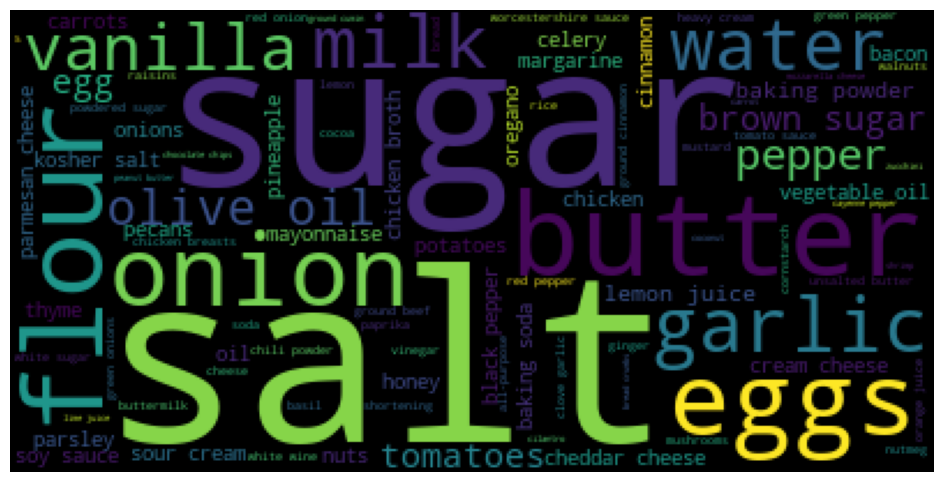

In [193]:
plt.figure(figsize=(12, 6))

plt.imshow(word_cloud_plot)

plt.axis("off")
plt.show()

<a id="datasets_five"></a>
### 2.5. Joined Recipe Dataset

In [194]:
recipes_food_com.columns.tolist(), recipes_allrecipes_com.columns.tolist()

(['Name',
  'CookTime',
  'PrepTime',
  'TotalTime',
  'Description',
  'RecipeCategory',
  'Keywords',
  'RecipeIngredientParts',
  'AggregatedRating',
  'ReviewCount',
  'RecipeInstructions',
  'ingredients_count',
  'instructions_count'],
 ['recipe_name',
  'ingredients',
  'cooking_directions',
  'ingredients_count',
  'instructions_count',
  'time_total',
  'time_cook',
  'time_prep'])

First we check for duplicate recipes:

In [195]:
names_food_com = set(recipes_food_com.Name)
names_allrecipes_com = set(recipes_allrecipes_com.recipe_name)
len(names_food_com), len(names_allrecipes_com)

(436247, 45060)

In [196]:
common_values = names_food_com.intersection(names_allrecipes_com)
len(common_values)

10964

A lot of duplicate titles, as expected. Let's explore a random one.

In [197]:
np.random.seed(seed=42)
random_duplicate_name = np.random.choice(list(common_values))
random_duplicate_name
   

'Vegan Chocolate Cake'

In [198]:
recipes_food_com[recipes_food_com.Name == random_duplicate_name].head()

,Name,CookTime,PrepTime,TotalTime,Description,RecipeCategory,Keywords,RecipeIngredientParts,AggregatedRating,ReviewCount,RecipeInstructions,ingredients_count,instructions_count
RecipeId,,,,,,,,,,,,,
9390,Vegan Chocolate Cake,30,10,40,Make and share this Vegan Chocolate Cake recip...,Dessert,"Low Protein, Vegan, Low Cholesterol, Kid Frien...","unbleached white flour, baking soda, sugar, wa...",5.0,8.0,Preheat oven to 375 degrees. Sift dry ingredie...,7,6
121804,Vegan Chocolate Cake,25,10,35,Make and share this Vegan Chocolate Cake recip...,Dessert,"Vegan, Low Cholesterol, Healthy, < 60 Mins, Easy","whole wheat flour, unbleached all-purpose flou...",5.0,1.0,"Preheat oven to 350 degrees. Oil two 8\"" round...",10,8
171933,Vegan Chocolate Cake,40,5,45,Found this at veganchocolate.com. It's labelle...,Dessert,"Lactose Free, Vegan, Low Cholesterol, Egg Free...","flour, sugar, salt, baking soda, vinegar, vani...",NaN,NaN,Add all of the dry ingredients to a bowl and m...,7,3
265009,Vegan Chocolate Cake,30,10,40,Make and share this Vegan Chocolate Cake recip...,Dessert,"< 60 Mins, Easy","whole wheat pastry flour, unbleached white flo...",NaN,NaN,bake it.,12,1
285066,Vegan Chocolate Cake,45,10,55,Make and share this Vegan Chocolate Cake recip...,Dessert,"Low Protein, Vegan, < 60 Mins","all-purpose flour, granulated sugar, cocoa pow...",NaN,NaN,For the cake: Preheat oven to 350 degrees. Lig...,14,4


In [199]:
recipes_allrecipes_com[recipes_allrecipes_com.recipe_name == random_duplicate_name]

,recipe_name,ingredients,cooking_directions,ingredients_count,instructions_count,time_total,time_cook,time_prep
recipe_id,,,,,,,,
16779,Vegan Chocolate Cake,"all-purpose flour, white sugar, cocoa powder, ...",{'directions': u'Prep 15 m Cook 45 m Ready In ...,9,9,60,45,15


We already know that we have duplicate titles that are not the same recipe, just the same dish. We check for duplicate indeces:

In [201]:
idx_food_com = set(recipes_food_com.index)
idx_allrecipes_com = set(recipes_allrecipes_com.index)
common_values = idx_food_com.intersection(idx_allrecipes_com)
len(common_values)

44103

To avoid mistakes because of the same indeces and keep track from which dataset is the recipe we add additional column with the old index preffixed by a letter - F for food.com and A for allrecipes.com.

In [202]:
recipes_food_com["old_index"] = [f"F{idx}" for idx in recipes_food_com.index]
recipes_allrecipes_com["old_index"] = [f"A{idx}" for idx in recipes_allrecipes_com.index]

In [203]:
recipes_food_com.head(2)

,Name,CookTime,PrepTime,TotalTime,Description,RecipeCategory,Keywords,RecipeIngredientParts,AggregatedRating,ReviewCount,RecipeInstructions,ingredients_count,instructions_count,old_index
RecipeId,,,,,,,,,,,,,,
38,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,Make and share this Low-Fat Berry Blue Frozen ...,Frozen Desserts,"Dessert, Low Protein, Low Cholesterol, Healthy...","blueberries, granulated sugar, vanilla yogurt,...",4.5,4.0,Toss 2 cups berries with sugar. Let stand for ...,4,8,F38
39,Biryani,25,240,265,Make and share this Biryani recipe from Food.com.,Chicken Breast,"Chicken Thigh & Leg, Chicken, Poultry, Meat, A...","saffron, milk, hot green chili peppers, onions...",3.0,1.0,Soak saffron in warm milk for 5 minutes and pu...,25,9,F39


In [204]:
recipes_allrecipes_com.head(2)

,recipe_name,ingredients,cooking_directions,ingredients_count,instructions_count,time_total,time_cook,time_prep,old_index
recipe_id,,,,,,,,,
240488,"Pork Loin, Apples, and Sauerkraut","sauerkraut drained, Granny Smith apples sliced...",{'directions': u'Prep 15 m Cook 2 h 30 m Ready...,12,11,165,150,15,A240488
218939,Foolproof Rosemary Chicken Wings,"chicken wings, sprigs rosemary, head garlic, o...","{'directions': u""Prep 20 m Cook 40 m Ready In ...",6,11,60,40,20,A218939


To join the tables we need same column names:

In [205]:
recipes_food_com = recipes_food_com.rename(columns = {
    "Name": "recipe_name", 
    "CookTime": "time_cook", 
    "PrepTime": "time_prep", 
    "TotalTime": "time_total", 
    "RecipeIngredientParts": "ingredients",
    "RecipeInstructions": "cooking_directions"
})

In [206]:
recipes_food_com.shape, recipes_allrecipes_com.shape

((520230, 14), (45630, 9))

We assume some of our numerical variables like time, ingredient count do not need normalization. This is not the case for review count, rating and instructions count (in one site were steps in the other sentences).

In [209]:
# todo: fix hist plot

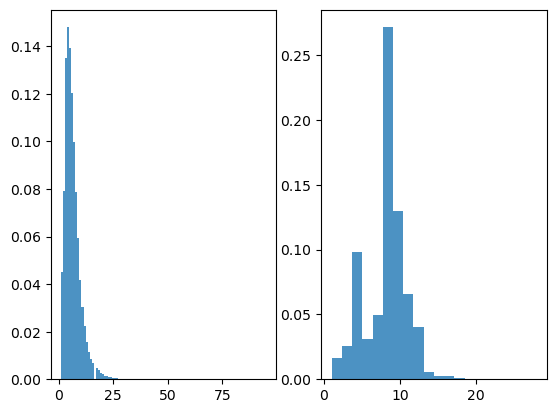

In [210]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(recipes_food_com.instructions_count, density = True, alpha = 0.8, bins = 100)
ax2.hist(recipes_allrecipes_com.instructions_count, density = True, alpha = 0.8, bins = 20)

plt.show()

In [211]:
recipes = pd.concat([recipes_food_com, recipes_allrecipes_com], axis = 0, ignore_index = True)

In [212]:
recipes.head()

,recipe_name,time_cook,time_prep,time_total,Description,RecipeCategory,Keywords,ingredients,AggregatedRating,ReviewCount,cooking_directions,ingredients_count,instructions_count,old_index
0,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,Make and share this Low-Fat Berry Blue Frozen ...,Frozen Desserts,"Dessert, Low Protein, Low Cholesterol, Healthy...","blueberries, granulated sugar, vanilla yogurt,...",4.5,4.0,Toss 2 cups berries with sugar. Let stand for ...,4,8,F38
1,Biryani,25,240,265,Make and share this Biryani recipe from Food.com.,Chicken Breast,"Chicken Thigh & Leg, Chicken, Poultry, Meat, A...","saffron, milk, hot green chili peppers, onions...",3.0,1.0,Soak saffron in warm milk for 5 minutes and pu...,25,9,F39
2,Best Lemonade,5,30,35,This is from one of my first Good House Keepi...,Beverages,"Low Protein, Low Cholesterol, Healthy, Summer,...","sugar, lemons, rind of, lemon, zest of, fresh ...",4.5,10.0,"Into a 1 quart Jar with tight fitting lid, put...",5,5,F40
3,Carina's Tofu-Vegetable Kebabs,20,1440,1460,This dish is best prepared a day in advance to...,Soy/Tofu,"Beans, Vegetable, Low Cholesterol, Weeknight, ...","extra firm tofu, eggplant, zucchini, mushrooms...",4.5,2.0,"Drain the tofu, carefully squeezing out excess...",14,13,F41
4,Cabbage Soup,30,20,50,Make and share this Cabbage Soup recipe from F...,Vegetable,"Low Protein, Vegan, Low Cholesterol, Healthy, ...","plain tomato juice, cabbage, onion, carrots, c...",4.5,11.0,Mix everything together and bring to a boil. R...,5,4,F42


In [213]:
recipes.shape

(565860, 14)

In [214]:
recipes.head(2) 

,recipe_name,time_cook,time_prep,time_total,Description,RecipeCategory,Keywords,ingredients,AggregatedRating,ReviewCount,cooking_directions,ingredients_count,instructions_count,old_index
0,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,Make and share this Low-Fat Berry Blue Frozen ...,Frozen Desserts,"Dessert, Low Protein, Low Cholesterol, Healthy...","blueberries, granulated sugar, vanilla yogurt,...",4.5,4.0,Toss 2 cups berries with sugar. Let stand for ...,4,8,F38
1,Biryani,25,240,265,Make and share this Biryani recipe from Food.com.,Chicken Breast,"Chicken Thigh & Leg, Chicken, Poultry, Meat, A...","saffron, milk, hot green chili peppers, onions...",3.0,1.0,Soak saffron in warm milk for 5 minutes and pu...,25,9,F39


This is the state of our dataframe that we think is the most human-friendly, so we keep it as recipes_book.

In [215]:
recipes.columns

Index(['recipe_name', 'time_cook', 'time_prep', 'time_total', 'Description',
       'RecipeCategory', 'Keywords', 'ingredients', 'AggregatedRating',
       'ReviewCount', 'cooking_directions', 'ingredients_count',
       'instructions_count', 'old_index'],
      dtype='object')

In [216]:
recipes_book = recipes[[
        'recipe_name', 'Description', 'RecipeCategory', 'Keywords', 
        'ingredients', 'cooking_directions', 'ingredients_count', 'instructions_count',
        'time_cook', 'time_prep', 'time_total',
        'AggregatedRating', 'ReviewCount', 'old_index' 
]]

In [217]:
recipes_book.head(2)

,recipe_name,Description,RecipeCategory,Keywords,ingredients,cooking_directions,ingredients_count,instructions_count,time_cook,time_prep,time_total,AggregatedRating,ReviewCount,old_index
0,Low-Fat Berry Blue Frozen Dessert,Make and share this Low-Fat Berry Blue Frozen ...,Frozen Desserts,"Dessert, Low Protein, Low Cholesterol, Healthy...","blueberries, granulated sugar, vanilla yogurt,...",Toss 2 cups berries with sugar. Let stand for ...,4,8,1440,45,1485,4.5,4.0,F38
1,Biryani,Make and share this Biryani recipe from Food.com.,Chicken Breast,"Chicken Thigh & Leg, Chicken, Poultry, Meat, A...","saffron, milk, hot green chili peppers, onions...",Soak saffron in warm milk for 5 minutes and pu...,25,9,25,240,265,3.0,1.0,F39


<a id="preprocess"></a>
### 3. Preprocess data

It is a bit blurry where EDA ends and preprocessing begins, but let's say here is where we start manipulating data so that they could be fed to our model.

We create another column called "word_soup" for obvious reasons, which will contain all text columns concatenated into one big string.

In [218]:
#recipes_allrecipes_com.cooking_directions = recipes_allrecipes_com.apply(lambda x: x.cooking_directions.replace(x.time, ""), axis = 1)

recipes.apply(lambda x: x.recipe_name, axis = 1)

0         Low-Fat Berry Blue Frozen Dessert
1                                   Biryani
2                             Best Lemonade
3            Carina's Tofu-Vegetable Kebabs
4                              Cabbage Soup
                        ...                
565855               Grateful Dead Cocktail
565856          Cheese Filling For Pastries
565857                       Peach Smoothie
565858                  Double Dare Peaches
565859           All-Purpose Marinara Sauce
Length: 565860, dtype: object

In [220]:
for column in ["recipe_name", "Description", "RecipeCategory", "Keywords", "ingredients", "cooking_directions"]:
    recipes[column] = recipes[column].fillna("")

In [221]:
recipes["word_soup"] = recipes.apply(lambda x: " ".join([
    x.recipe_name, 
    x.Description, 
    x.RecipeCategory, 
    x.Keywords, 
    x.ingredients, 
    x.cooking_directions
]), axis = 1)

In [222]:
recipes.head(2)

,recipe_name,time_cook,time_prep,time_total,Description,RecipeCategory,Keywords,ingredients,AggregatedRating,ReviewCount,cooking_directions,ingredients_count,instructions_count,old_index,word_soup
0,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,Make and share this Low-Fat Berry Blue Frozen ...,Frozen Desserts,"Dessert, Low Protein, Low Cholesterol, Healthy...","blueberries, granulated sugar, vanilla yogurt,...",4.5,4.0,Toss 2 cups berries with sugar. Let stand for ...,4,8,F38,Low-Fat Berry Blue Frozen Dessert Make and sha...
1,Biryani,25,240,265,Make and share this Biryani recipe from Food.com.,Chicken Breast,"Chicken Thigh & Leg, Chicken, Poultry, Meat, A...","saffron, milk, hot green chili peppers, onions...",3.0,1.0,Soak saffron in warm milk for 5 minutes and pu...,25,9,F39,Biryani Make and share this Biryani recipe fro...


In [224]:
print_values_in_first_n_rows(recipes, "word_soup", n = 2)

Low-Fat Berry Blue Frozen Dessert Make and share this Low-Fat Berry Blue Frozen Dessert recipe from Food.com. Frozen Desserts Dessert, Low Protein, Low Cholesterol, Healthy, Free Of..., Summer, Weeknight, Freezer, Easy blueberries, granulated sugar, vanilla yogurt, lemon juice Toss 2 cups berries with sugar. Let stand for 45 minutes, stirring occasionally. Transfer berry-sugar mixture to food processor. Add yogurt and process until smooth. Strain through fine sieve. Pour into baking pan (or transfer to ice cream maker and process according to manufacturers' directions). Freeze uncovered until edges are solid but centre is soft.  Transfer to processor and blend until smooth again. Return to pan and freeze until edges are solid. Transfer to processor and blend until smooth again.", 
"Fold in remaining 2 cups of blueberries. Pour into plastic mold and freeze overnight. Let soften slightly to serve.

Biryani Make and share this Biryani recipe from Food.com. Chicken Breast Chicken Thigh & L

In [157]:
#recipes.word_soup.str.replace(r'\d', "") # todo: remove special chars

The following code makes dummys for the most common ingredients (most common in NLGRecipes dataset). My old machiene and my patience both say we need to drop some of them. We decide on a threshold of occurrences:

In [225]:
threshold = 10000

In [226]:
most_common_thresholded = most_common_ingredients[most_common_ingredients.occurences > threshold]

In [227]:
most_common_thresholded

,ingredient,occurences
0,salt,1013708
1,sugar,662832
2,butter,539978
3,flour,488086
4,eggs,422212
...,...,...
263,oatmeal,10255
264,pastry,10186
265,cake,10168
266,cake flour,10134


In [228]:
ingredients_df = pd.DataFrame(0, index=recipes.index, columns = most_common_thresholded.ingredient) # new dataframe with zeroes

In [229]:
for ingredient_name in most_common_thresholded.ingredient:
    ingredients_df[ingredient_name] = np.where(recipes.ingredients.str.contains(ingredient_name, regex = False, case = False), 1, 0)

In [230]:
#recipes = recipes.drop(columns=["ingredients"])

In [231]:
#recipes = recipes.drop(columns = ["recipe_name", "Description", "RecipeCategory", "Keywords", "cooking_directions"])

In [232]:
ingredients_df.head(3)

ingredient,salt,sugar,butter,flour,eggs,onion,garlic,milk,water,vanilla,...,macaroni,topping,ground coriander,heavy whipping cream,cayenne,oatmeal,pastry,cake,cake flour,turkey
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [233]:
ingredients_df.shape

(565860, 268)

We decided to keep relatively big number of ingredients. To speed up things, we need dimensionality reduction and we choose PCA, which we think will be very suitable, since groups of ingredients are frequently used together for different types of dishes. We decide to not include other columns (such as times and ratings) since we preffer to keep more interpretability.

In [234]:
n_components = 50

In [235]:
pca = PCA(n_components)

In [236]:
ingredients_transformed = pca.fit_transform(ingredients_df)

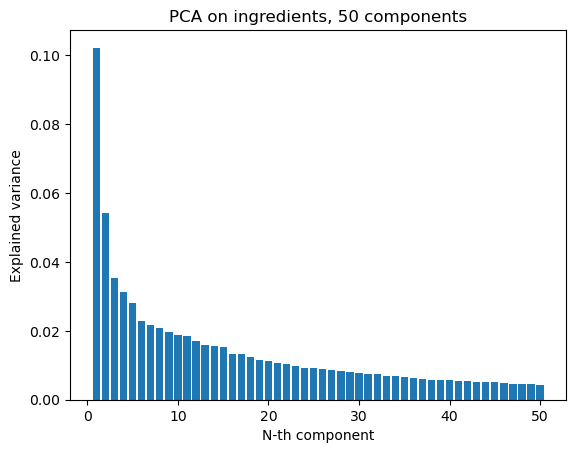

In [237]:
plt.bar(np.arange(1, n_components + 1), pca.explained_variance_ratio_)

plt.title(f"PCA on ingredients, {n_components} components")
plt.xlabel("N-th component")
plt.ylabel("Explained variance")

plt.show()

In [238]:
pca.explained_variance_ratio_.sum()

0.7042215989413911

With only 20 components we can account for almost half the varience of the almost 300 ingredients we kept. Maybe keeping more principal components would be beneficial, but we don't have the time for that. So, a pretty plot of the recipes according to the first 2 principal components and number of ingredients in the recipe trying to look for groups or patterns.

In [239]:
# ingredients_transformed

In [240]:
ingredients_transformed.shape

(565860, 50)

In [241]:
groups_to_visualise = np.arange(1, 26)
groups_to_visualise

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

In [242]:
n_types = len(groups_to_visualise)

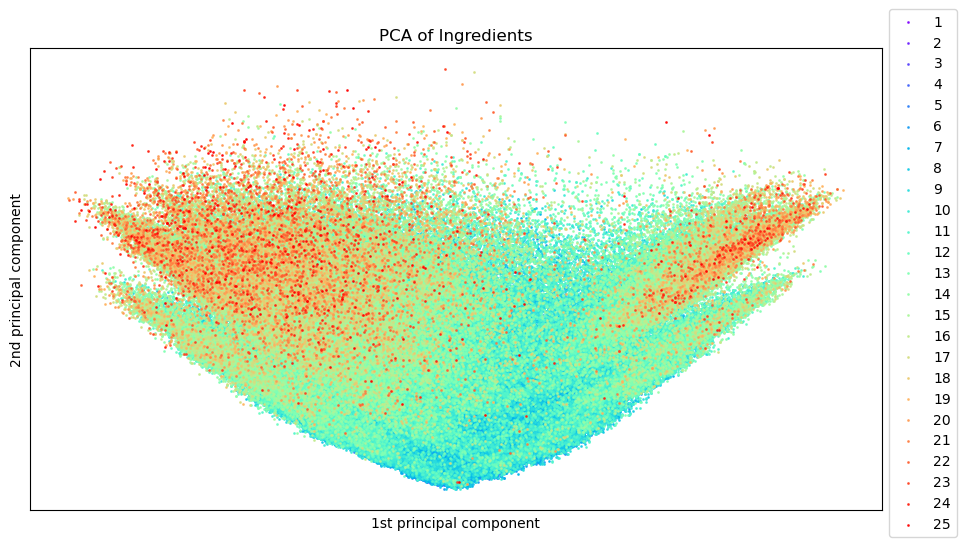

In [243]:
plt.figure(figsize=(11,6))

colormap = plt.cm.rainbow(np.linspace(0, 1, n_types))

for i, group_type in enumerate(groups_to_visualise):
    plt.scatter(
        ingredients_transformed[recipes["ingredients_count"] == group_type, 0], 
        ingredients_transformed[recipes["ingredients_count"] == group_type, 1], 
        alpha=0.8, 
        label=group_type,
        color = colormap[i],
        s = 1
    )
    
plt.xticks([])
plt.yticks([])
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.legend(bbox_to_anchor=(1, 1.1), shadow=False, scatterpoints = 1)
plt.title("PCA of Ingredients")


plt.show()

There may be a separation in two groups of the recipes with more than, say 15 ingredients, and the overall shape of the dot-clouds is wired but nothing we can use for the modeling so off to the word soup.

In [244]:
#recipes.describe().T

In [245]:
recipes.dtypes

recipe_name            object
time_cook               int32
time_prep               int32
time_total              int32
Description            object
RecipeCategory         object
Keywords               object
ingredients            object
AggregatedRating      float64
ReviewCount           float64
cooking_directions     object
ingredients_count       int64
instructions_count      int64
old_index              object
word_soup              object
dtype: object

We vectorise the text with *Term Frequency-Inverse Document Frequency* or TF-IDF. 

In [248]:
tfidf = TfidfVectorizer(
    stop_words="english", 
    max_features = 10000, 

) # n_grams; remove numbers?

In [249]:
word_soup_tfidf = tfidf.fit_transform(recipes.word_soup)

In [250]:
word_soup_tfidf.shape

(565860, 10000)

In [ ]:
tfidf.get_feature_names_out()

In [366]:
tfidf_scores_sorted = np.argsort(np.asarray(word_soup_tfidf.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tfidf.get_feature_names_out())

In [372]:
tfidf_feature_names[tfidf_scores_sorted[:100]]

array(['chicken', 'cheese', 'add', 'sugar', 'minutes', 'butter', 'salt',
       'pepper', 'heat', 'sauce', 'cook', 'flour', 'water', 'oil',
       'cream', 'garlic', 'stir', 'oven', 'onion', 'mix', 'recipe',
       'baking', 'low', 'easy', 'pan', 'mixture', 'make', 'bowl', 'milk',
       'mins', 'place', 'food', 'large', 'powder', 'eggs', 'bake',
       'brown', 'lemon', 'ingredients', 'rice', 'meat', 'medium', '15',
       'juice', 'fresh', 'com', '30', 'potatoes', 'share', 'ground',
       'egg', 'combine', 'vanilla', 'hours', 'serve', 'dish', 'olive',
       'chocolate', 'tomatoes', 'beans', 'beef', 'green', 'pour',
       'onions', 'bread', 'cover', 'remove', 'cake', '10', 'degrees',
       'salad', 'cool', 'vegetable', '60', 'soup', 'high', 'dough', 'cup',
       'skillet', 'red', 'boil', 'hot', 'black', 'cinnamon', 'half',
       'pasta', 'small', 'white', 'use', 'cut', 'remaining', 'sprinkle',
       'time', 'pie', 'tomato', 'dessert', 'set', 'stirring', 'simmer',
       'pork']

In [373]:
tfidf_feature_names[tfidf_scores_sorted[-100:]]

array(['authors', 'extracted', 'matters', 'rearrange', 'nathan',
       'represent', 'efforts', 'ap', 'borders', 'purees', 'reveal',
       'fleshy', 'butchers', 'precious', 'noticeable', 'circumference',
       'ecirc', 'oiling', 'crosshatch', 'stopper', 'afterward',
       'popularity', '200ml', 'pleating', 'ink', 'wiped', 'bunnies',
       'novice', '8243', 'nervous', 'beards', 'nestled', 'coils',
       'whistles', 'reward', 'burdock', 'wikipedia', 'vice', 'heels',
       'ruler', 'grooves', 'centimeter', 'thumped', 'cylindrical',
       'excessively', 'knuckle', 'dorie', 'movement', 'kg', 'worse',
       'seize', 'ragged', 'yeasty', 'workbowl', 'hairy', 'netting', '30g',
       'skill', 'tiles', 'application', 'separator', 'branches',
       'soufflés', 'opens', 'environment', 'unevenly', 'fins', '195',
       'aerate', 'lan', 'grasp', 'usda', 'probe', 'feathers', 'recipient',
       'cheeks', 'clockwise', 'dp', 'macarons', 'encased', 'frites',
       'rocking', 'rimless', 'sauceb

In [374]:
# tfidf.vocabulary_

We reduce the number of text-related features with Truncated SVD:

In [260]:
n_features_svd = 100

In [261]:
svd = TruncatedSVD(n_features_svd)

In [262]:
word_soup_transformed = svd.fit_transform(word_soup_tfidf)

In [263]:
word_soup_transformed.shape

(565860, 100)

In [264]:
sum(svd.explained_variance_ratio_)

0.30205537711368385

<a id="model"></a>
## 4. Model

For our model we choose Nearest Neighbors, as it is unsupervised, quick way to find weather our features processing works. It is not without drawbacks - first we do not have a way to accurately evaluate the model, we can only try to test some some random samples and decide very subjectively whether it works. Training a KNeighborsClassifier would give us a way to score it, but we do not have categories for our second dataset and we presume assigning categories in our case is generally bad idea, as with recipes multiple categories could be assigned and they are rather subjective. 

In [ ]:
# 'time_cook', 'time_prep', 'time_total', 'ingredients',
#        'AggregatedRating', 'ReviewCount', 'ingredients_count',
#        'instructions_count'

In [265]:
features_combined = np.hstack((ingredients_transformed, word_soup_transformed))

In [266]:
features_combined.shape

(565860, 150)

In [300]:
nn = NearestNeighbors(n_neighbors=10)

In [301]:
nn.fit(features_combined)

NearestNeighbors(n_neighbors=10)

Now the moment we've been waiting for... recommend similar recipes to:

In [302]:
np.random.seed(42)
idx_test = np.random.choice(recipes.index)

In [303]:
idx_test # 121958

121958

In [304]:
sample_1 = features_combined[idx_test].reshape(1, -1)

In [305]:
sample_1.shape

(1, 150)

In [306]:
sample_neighbours = nn.kneighbors(sample_1, return_distance = False) 

In [307]:
sample_neighbours = sample_neighbours.flatten().tolist()
sample_neighbours

[121958, 2905, 172755, 18493, 243986, 28907, 82513, 68075, 29834, 36464]

In [308]:
recipes_book[(recipes.index == sample_neighbours[0]) | (recipes.index == sample_neighbours[1]) | (recipes.index == sample_neighbours[2]) | (recipes.index == sample_neighbours[3]) | (recipes.index == sample_neighbours[4])]

,recipe_name,Description,RecipeCategory,Keywords,ingredients,cooking_directions,ingredients_count,instructions_count,time_cook,time_prep,time_total,AggregatedRating,ReviewCount,old_index
2905,Cheesecake Brownies,Make and share this Cheesecake Brownies recipe...,Bar Cookie,"Dessert, Cookie & Brownie, Kid Friendly, < 60 ...","egg, margarine, confectioners' sugar, eggs, cr...","Preheat oven to 325°F. Mix together cake mix, ...",5,4,30,5,35,4.0,2.0,F4565
18493,Lemon Squares,These squares are tart and sweet at the same t...,Bar Cookie,"Dessert, Cookie & Brownie, Lemon, Citrus, Frui...","margarine, egg, cream cheese, eggs, icing sugar","Grease and flour 9x13-inch pan. Mix cake mix, ...",5,7,40,20,60,4.5,2.0,F21929
121958,Smash Cake,Make and share this Smash Cake recipe from Foo...,Bar Cookie,"Dessert, Cookie & Brownie, Toddler Friendly, K...","margarine, egg, cream cheese, eggs, powdered s...",Mix the first three ingredients together. Pres...,5,6,40,5,45,5.0,9.0,F128755
172755,Buttermilk Squares,Make and share this Buttermilk Squares recipe ...,Dessert,"Kid Friendly, Potluck, Sweet, < 60 Mins, For L...","margarine, eggs, powdered sugar, cream cheese",Melt margarine in 13 X 9 pan. Mix 2 eggs and c...,4,4,35,15,50,5.0,3.0,F181389
243986,Chess Cake,Make and share this Chess Cake recipe from Foo...,Dessert,"< 60 Mins, Beginner Cook, Easy","margarine, egg, powdered sugar, cream cheese, ...","Mix together cake mix, margarine, and 1 egg;. ...",5,5,40,5,45,5.0,1.0,F255038


First result is ...meh... but could'have been worse - at least all 5 dishes have vegetables (somewhat repeating) with cheese and green herbs. One thing worth mentioning is that they come from the same original dataset - so we might have done better normalisation before concatenating.

In [279]:
old_idx_neighbours = [recipes.old_index[i] for i in sample_neighbours]
old_idx_neighbours

['F128755', 'F4565', 'F181389', 'F21929', 'F255038']

...and we find out that the links for the images in the first dataset are no longer functional, so lets *randomly* (or not so randomly) select starting recipe that will return neighbours in the second dataset.

Lets put that into a function:

In [280]:
def neighbours_from_idx(test_idx):
    sample = features_combined[idx_test].reshape(1, -1)
    sample_neighbours = nn.kneighbors(sample, return_distance = False) 
    sample_neighbours = sample_neighbours.flatten().tolist()
    
    return sample_neighbours

In [281]:
# def neighbours_book(sample_neighbours):
#     return recipes_book[(recipes.index == sample_neighbours[0]) | (recipes.index == sample_neighbours[1]) | (recipes.index == sample_neighbours[2]) | (recipes.index == sample_neighbours[3]) | (recipes.index == sample_neighbours[4])]

In [320]:
def neighbours_book(sample_neighbours):
    return recipes_book.iloc[sample_neighbours]

In [282]:
def to_old_idx(sample_neighbours):
    return [recipes.old_index[i] for i in sample_neighbours]

In [321]:
ds_2_for_test = recipes_book[recipes_book.old_index.str.contains("A")]

In [322]:
idx_test = np.random.choice(ds_2_for_test.index)

In [323]:
idx_test

521090

In [324]:
sample = neighbours_from_idx(4567)
sample

[521090, 157891, 6422, 190416, 368822, 11963, 386151, 38315, 26284, 213198]

In [325]:
to_old_idx(sample)

['A233238',
 'F166050',
 'F9430',
 'F199647',
 'F383926',
 'F15215',
 'F401807',
 'F42223',
 'F29906',
 'F223195']

In [326]:
neighbours_book(sample)

,recipe_name,Description,RecipeCategory,Keywords,ingredients,cooking_directions,ingredients_count,instructions_count,time_cook,time_prep,time_total,AggregatedRating,ReviewCount,old_index
521090,Coney Island Hot Dog Chili Sauce,NaN,NaN,NaN,"ground round, water, tomato paste, sweet pickl...",{'directions': u'Prep 15 m Cook 35 m Ready In ...,10,7,35,15,50,NaN,NaN,A233238
157891,Round Steak Barbecue,Make and share this Round Steak Barbecue recip...,Steak,"Meat, Tex Mex, Southwestern U.S., < 4 Hours, I...","sugar, salt, seasoning salt, onion, water, Wor...",Cut meat into servicg pieces. In large skillet...,8,4,90,15,105,5.0,4.0,F166050
6422,Simmered Round Steak,Make and share this Simmered Round Steak recip...,Steak,"Meat, Weeknight, < 4 Hours","onion, sugar, salt, Worcestershire sauce, prep...",Trim fat from steak and cut meat into serving ...,7,6,120,20,140,5.0,45.0,F9430
190416,Sunita's Sooji Upma,Here in Mumbai I had a maid named Sunita who w...,Breakfast,"Vegetable, Asian, Indian, Vegan, Savory, Brunc...","semolina, mustard seeds, cumin seed, curry lea...",Roast the semolina in a wok until lightly gold...,11,11,20,20,40,NaN,1.0,F199647
368822,Sweet and Sour Venison Stew,This a very simple recipe my Wife came up with...,Stew,"Meat, < 4 Hours","onion, Worcestershire sauce, ketchup, water, v...",Cut the Venison into bite size pieces and brow...,9,4,60,20,80,3.0,1.0,F383926
11963,Beef Burgers,I divide this into several small containers an...,Lunch/Snacks,"Grains, Meat, High Protein, Kid Friendly, High...","hamburger, chili powder, salt, onion, catsup, ...",Add the first 4 ingredients together and brown...,9,4,20,20,40,4.5,2.0,F15215
386151,Bagara Dahi (Curried Yogurt Indian Style),Bagara Dahi is a yum way to prepare yogurt. It...,< 15 Mins,NaN,"yoghurt, onion, curry leaves, mustard seeds, j...",Heat oil in a pan and add asafoetida. Cook for...,12,9,5,10,15,NaN,NaN,F401807
38315,Cabbage Salad,Dedicated to Charishma and all those trying to...,Vegetable,"Low Protein, Low Cholesterol, Healthy, < 15 Mins","abbage, red capsicum, tomatoes, onion, sugar, ...",Mix all the vegetables. Add the sugar and pour...,7,9,1,10,11,4.0,3.0,F42223
26284,Lonnie's Mom's Barbecue Roast Beef,This is one of those picnic/church supper thin...,Lunch/Snacks,"Meat, Potluck, Weeknight, Roast, Oven","beef roast, onion, vinegar, yellow mustard, su...",Put everything but the beef in a saucepan simm...,11,6,180,1440,1620,NaN,NaN,F29906
213198,Kids' Favorite Sloppy Joes,"This is a super-simple, sweet'n tangy, kid-fri...",One Dish Meal,"Meat, Kid Friendly, < 30 Mins, Beginner Cook, ...","hamburger, onion, ketchup, water, prepared mus...",Brown the hamburger and onion together. Pour o...,8,4,10,15,25,4.0,2.0,F223195


In [327]:
old_idx_neighbours = [recipes.old_index[i] for i in sample_neighbours]
old_idx_neighbours

['F128755',
 'F4565',
 'F181389',
 'F21929',
 'F255038',
 'F32590',
 'F87931',
 'F72943',
 'F33539',
 'F40326']

After spending considerable amount of time searching for an recipe that will give result in the dataset with images, we have drawn two conclusions:

1. Our model is not a total failure because it groups recipes with similar ingredients and categories, but a simple search by main ingredient would return better results, so it IS a failure.
2. Second dataset is too small, so adding pretty pictures and commenting the similarity in them is not going to happen.

Now to satisfy our curiosity, we infer on an zero vector:

In [328]:
input_shape = sample_1.shape
input_shape

(1, 150)

In [329]:
zero = np.zeros(input_shape)
zero

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]])

In [330]:
sample_neighbours = nn.kneighbors(zero, return_distance = False)

In [331]:
sample_neighbours = sample_neighbours.flatten().tolist()
sample_neighbours

[50980, 140728, 306324, 407398, 70892, 329834, 356360, 158514, 87304, 39534]

In [332]:
to_old_idx(sample_neighbours)

['F55288',
 'F148202',
 'F319589',
 'F424132',
 'F75869',
 'F343824',
 'F371082',
 'F166689',
 'F92858',
 'F43480']

In [333]:
neighbours_book(sample_neighbours)

,recipe_name,Description,RecipeCategory,Keywords,ingredients,cooking_directions,ingredients_count,instructions_count,time_cook,time_prep,time_total,AggregatedRating,ReviewCount,old_index
50980,Acne Drying Lotion,I once read that this is what cosmetics mogul ...,Homeopathy/Remedies,"< 15 Mins, Easy",alum,Measure 1/4 cup witch hazel and mix in the pin...,1,3,0,2,2,NaN,NaN,F55288
140728,Holiday Candy Trains,Make and share this Holiday Candy Trains recip...,Toddler Friendly,"Kid Friendly, Christmas, < 60 Mins",raisins,"For cars of each train, glue end of 1 ribbon o...",1,5,0,60,60,NaN,NaN,F148202
306324,Beer Shampoo,I found this recipe during my travels. I have...,Bath/Beauty,"< 15 Mins, Easy",beer,"In a saucepan, boil the beer until it is reduc...",1,2,10,5,15,NaN,NaN,F319589
407398,Beijing Bellini,Posted for ZWT6. Lychee liquor replaces tradi...,Beverages,"< 15 Mins, Easy",lychee,Blend Champagne and Lychee wine or liquor in a...,1,2,0,1,1,5.0,1.0,F424132
70892,Grass Greening Motivator,Make and share this Grass Greening Motivator r...,Household Cleaner,"< 15 Mins, Easy","molasses, beer","Combine the molasses,beer,and dish soap in a 2...",2,3,0,10,10,5.0,2.0,F75869
329834,Christmas Angel Hershey Kiss Ornament Craft,I realize this isn't technically a recipe - bu...,Christmas,"< 15 Mins, For Large Groups, Beginner Cook, Ea...",rum,You will also need:. 24 white beads (about the...,1,6,0,5,5,4.5,2.0,F343824
356360,Spirit Lift - Sleep Aid Herbal Blend,This mix of all natural herbs is designed to i...,< 15 Mins,Easy,herbs,Mix herbs together and consume by mixing with ...,1,2,0,5,5,NaN,NaN,F371082
158514,Lobster and Cous Cous Sushi,This was an original idea I had of using cous ...,Lobster,"Japanese, Asian, Australian, < 15 Mins, Easy","ouscous, lobster tails, wasabi",Place cous cous onto sushi sheets as you would...,3,2,5,5,10,NaN,NaN,F166689
87304,Williamsburg Inn Mixed Nut Condiment,Had this on a buffet table at the Williamsburg...,< 15 Mins,Easy,"Major Grey chutney, Grand Marnier",Mix all ingredients well. If too dry add more ...,2,3,0,5,5,NaN,NaN,F92858
39534,Reindeer Dust/Food,I got this off the Internet and have done this...,Low Cholesterol,"High Protein, Healthy, High In..., Christmas, ...",oatmeal,Place oatmeal in a small zip-lock baggie. Add ...,1,8,0,0,0,5.0,6.0,F43480


Weird recipes with nothing in common to comment so here's the one with picture, just because...

In [334]:
recipes_allrecipes_com_meta[212443]

'https://images.media-allrecipes.com/userphotos/720x405/2614758.jpg'

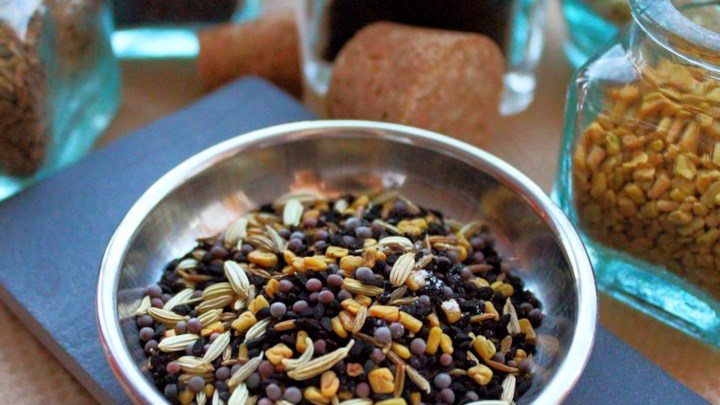

Is that even a recipe? Let's wrap this up and go to conclusion.

<a id="conclusion"></a>
## Conclusion

Our results lead to following conclusion: the model fails at achieving its goal - clustering similar recipes. For future work these steps should be considered:

1. Investigate PCA on ingredients results - combined explained variance ratio is very low, so bigger number of components should be considered. This would lead to even slower model, so lowering the number of most common ingredients could also be beneficial (better have a good description on small number of variables than bad description on large). Replacing the PCA on indicator variables with some kind of text processing might also lead to better results. TF-IDF however is not a good approach, since it penalizes frequently used terms in the different recipes - meaning it will give low score on most common ingredients as salt, sugar and butter, which is not desirable.

2. We presume bad results of SVD on the text features is related to bad preprocessing. The initial huge length of single-word-tockens was 500 000 (before we limited it to 10 000) leads to the conclusion that we forgot to get rid of numbers and special symbols, which carry almost no information since we do not consider quantitys anywhere, and a lot of numbers and special charactes are expected coming from measuring units and pseudo-French cuisine.

3. If all attempts at unsupervised clustering fail, a supervised clustering or classification are the next option.

4. Numerical features could be added to the model at some point and their contribution to the performance must be evaluated.

   

We need much more time, work and understanding to make anything with real value out of the initial idea. Getting here however, was fun and educational and I (f with the we) hope that I get to finish this research some time soon.
And for "The End" here's an image from the dataset I downloaded for an hour, but never get to process, because it is *almost* that time of the year:

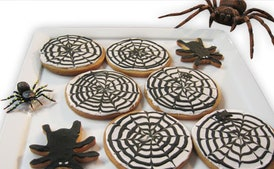

<a id="ref"></a>
### References

* [RECipe: Does a Multi-Modal Recipe Knowledge Graph Fit a Multi-Purpose
Recommendation System?](https://arxiv.org/pdf/2308.04579.pdf)

* [Recipe1M+: A Dataset for Learning Cross-Modal Embeddings for Cooking Recipes and Food Images](https://arxiv.org/pdf/1810.06553v2.pd)

* [Article Recommendation System Using Python](https://medium.com/web-mining-is688-spring-2021/article-recommendation-system-using-python-8b0fec6e6de8)

* [Word Embedding Explained, a comparison and code tutorial](https://medium.com/@dcameronsteinke/tf-idf-vs-word-embedding-a-comparison-and-code-tutorial-5ba341379ab0)

* [K-Nearest Neighbors: All you need to know](https://medium.com/analytics-vidhya/k-nearest-neighbors-all-you-need-to-know-1333eb5f0ed0))

<a id="DS"></a>

Datasets:

* [Food.com - Recipes and Reviews](https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews)

* [Allrecipes.com - foodRecSys-V1](https://www.kaggle.com/datasets/elisaxxygao/foodrecsysv1)

* [Epicurious.com - Food Ingredients and Recipes Dataset with Images](https://www.kaggle.com/datasets/pes12017000148/food-ingredients-and-recipe-dataset-with-images)

* [RecipeNLG dataset - extended Recipe1M+ dataset](https://www.kaggle.com/datasets/saldenisov/recipenlg)